# Lombard Lending: modeling lending values

Based on Juri (2014), Lending Values and Liquidity Risk

Applied Credit Risk Modeling Seminar FS2021

Hubert Mrugala and Wenqi Li

## Packages, functions and the data

In [5]:
# Loading packages
import numpy as np
import pandas as pd
import datetime
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels
import scipy.stats as st

In [6]:
# Calculate log returns
def log_returns(prices):
    return np.log(prices/prices.shift(1))

def ADTV(volumes):
    adtv = pd.DataFrame(data=[volumes.iloc[-20:,:].mean(),
                              volumes.iloc[-250*3:,:].mean()],
                        index=['ADTV - Last month','ADTV - Last three years']) \
                        .transpose()
    return adtv

# ---------------------------------

def mean(log_prices):
    return log_prices.mean()

# Return standard deviation of a time series
def std(log_prices):
    return log_prices.std()

# def volatility(log_prices):
#     return 

# def EWMA(log_prices):
#     return 

# def GARCH11(log_prices):
#     return 

# ---------------------------------

# Return drift and diffusion used to model the asset price process
def GBM(log_prices):
    mu = log_prices.mean()
    sigma = log_prices.std()
    drift = (mu-sigma**2/2)*delta
    diffusion = sigma**2*delta
    return drift, diffusion

# Lending Value (not adjusted)
def LV(log_prices,alpha,epsilon,delta):
    mu = mean(log_prices)
    sigma = std(log_prices)
    drift = GBM(log_prices)[0]
    diffusion = GBM(log_prices)[1]
    lv = ( (1-alpha)*(np.exp(drift+sigma*np.sqrt(delta)*st.norm.ppf(epsilon))) ) / \
    ( 1-alpha*(np.exp(drift+sigma*np.sqrt(delta)*st.norm.ppf(epsilon))) )
    return lv

# Estimate gamma by using ADTV
def gamma_est(ADTV,a_hat,b_hat):
    return 10**a_hat*ADTV**b_hat

# Lending Value adjusted for liquidity
def LV_adj(log_prices,alpha,epsilon,delta,gamma,x):
    mu = mean(log_prices)
    sigma = std(log_prices)
    drift = GBM(log_prices)[0]
    diffusion = GBM(log_prices)[1]
    lv_adj = ( (1-alpha)*(np.exp(-gamma*x+drift+sigma*np.sqrt(delta)*st.norm.ppf(epsilon))) ) / \
    ( 1-alpha*(np.exp(-gamma*x+drift+sigma*np.sqrt(delta)*st.norm.ppf(epsilon))) )
    return lv_adj

def lvx(log_returns,alpha,epsilon,delta,gamma,x_range):
    lvs = []
    for i in range(len(x_range)):
        lv_adj = LV_adj(log_returns,
                        alpha,epsilon,delta,
                        gamma,
                        x_range[i])
        lvs.append(lv_adj)
    return lvs

# ---------------------------------

def reindex_monthly(series):
    return series.resample('BMS').first()
    
def reindex_weekly(series):
    return series.resample('W').first()

def describe(series):
    stats = pd.DataFrame(data=[(series.iloc[-1] - series.iloc[0]) / series.iloc[-1]*100,
                               series.min(),
                               series.max(),
                               series.median(),
                               series.mean(),
                               series.std(),
                               series.skew(),
                               series.kurtosis()],
                         index=['% Change','Min','Max','Median','Mean',
                                'Standard Deviation','Skewness','Kurtosis']).T
    alpha = 0.01
    VaRs = []
    for i in range(len(series.columns)):
        series_i_VaR = value_at_risk(series.iloc[:,i],alpha)
        VaRs.append(series_i_VaR)
    ESs = []
    for i in range(len(series.columns)):
        series_i_ES = expected_shortfall(series.iloc[:,i],alpha)
        ESs.append(series_i_ES)
    
    stats['Value at Risk'] = VaRs
    stats['Expected Shortfall'] = ESs
    
    return stats.T

def four_moments(equity_prices,market_prices):
    x = equity_prices.interpolate()
    y = market_prices
    
    n = len(x)
    
    # market price obs are less than equity price obs
    # so make those two equal
    x = x.reindex(y.index)
    
    x = np.array(x).reshape(len(x))
    y = np.array(y).reshape(len(y))
    
    de_mean_x = x - mean(x)
    de_mean_y = y - mean(y)
    
    cov = np.dot(de_mean_x,de_mean_y) / (n-1)
    corr = cov / (std(x)*std(y)) 
    
    cov2 =  np.dot(de_mean_x,de_mean_y**2) / (n-1)
    coskew = cov2 / (std(x)*std(y)**2)
    
    cov3 = np.dot(de_mean_x,de_mean_y**3) / (n-1)
    cokurt = cov3 / (std(x)*std(y)**3)
    return corr, coskew, cokurt

# ---------------------------------

def value_at_risk(returns,alpha):
    returns = returns.sort_values(ascending=True)
    n = len(returns)
    k = int(np.floor(n*alpha))
    return -returns[k-1+1]

# def VaR(returns,alpha):
#     returns = returns.sort_values(ascending=True)
#     var = -cs_returns.quantile(alpha,'lower')
#     return var

def VaR_series(returns):
    VaRs = []
    for i in range(20,len(returns)):
        val_at_risk = value_at_risk(returns.iloc[20:20+i],0.01)
        VaRs.append(val_at_risk)
    VaRs = pd.Series(VaRs,index=returns.index[20:])
    return VaRs

def expected_shortfall(returns,alpha):
    var = -value_at_risk(returns,alpha)
    return -returns[returns<var].mean()

def compounded_date(logs,start_date,end_date):
    start_num = (logs == logs[start_date]).argmax()
    end_num = (logs == logs[end_date]).argmax()+1

    comp = []
    for i in range(start_num,end_num):
        ret = logs[start_num:i].sum()
        comp.append(ret)
    comp = pd.Series(comp)
    comp.index = logs[start_num:end_num].index
    return comp

def compounded(logs):
    start = 1
    end = len(logs)

    comp = []
    for i in range(start,end):
        ret = logs[1:i].sum()
        comp.append(ret)
    comp = pd.Series(comp)
    comp.index = logs.index[1:]
    return comp

In [7]:
start_date = '2018-04-03'
end_date = '2021-04-09'

In [8]:
# Load/Create Data
smi_prices = pd.read_csv('data/smi_prices.csv',index_col='Date')[start_date:end_date].interpolate()
smi_prices.index = pd.to_datetime(smi_prices.index)

smi_returns = smi_prices.pct_change()
smi_logs = log_returns(smi_prices)

smi_vols = pd.read_csv('data/smi_volumes.csv',index_col='Date')[start_date:end_date].interpolate()
smi_vols.index = pd.to_datetime(smi_vols.index)

# ---------------------------------

smi20_prices = pd.read_csv('data/smi_index_prices.csv',index_col='Date')[start_date:end_date].interpolate()
smi20_prices.index = pd.to_datetime(smi20_prices.index)

smi20_returns = smi20_prices.pct_change()
smi20_logs = log_returns(smi20_prices)

sp500_prices = pd.read_csv('data/sp500_index_prices.csv',index_col='Date')[start_date:end_date].interpolate()
sp500_prices.index = pd.to_datetime(sp500_prices.index)

sp500_returns = sp500_prices.pct_change()
sp500_logs = log_returns(smi_prices)

# ---------------------------------

selected = ['Credit Suisse','Richemont','Swisscom','SGS']

selected_prices = smi_prices[selected]
selected_vols = smi_vols[selected]
selected_returns = smi_returns[selected]
selected_logs = smi_logs[selected]

# ---------------------------------

cs_prices = smi_prices['Credit Suisse']
cs_returns = smi_returns['Credit Suisse']
cs_logs = smi_logs['Credit Suisse']
cs_vols = smi_vols['Credit Suisse']

rich_prices = smi_prices['Richemont']
rich_returns = smi_returns['Richemont']
rich_logs = smi_logs['Richemont']
rich_vols = smi_vols['Richemont']

scom_prices = smi_prices['Swisscom']
scom_returns = smi_returns['Swisscom']
scom_logs = smi_logs['Swisscom']
scom_vols = smi_vols['Swisscom']

sgs_prices = smi_prices['SGS']
sgs_returns = smi_returns['SGS']
sgs_logs = smi_logs['SGS']
sgs_vols = smi_vols['SGS']

## The Data and Basic Statistics

In [9]:
smi_adtv = ADTV(smi_vols).astype(int)
smi_adtv.sort_values(by='ADTV - Last month',ascending=False)

,ADTV - Last month,ADTV - Last three years
Credit Suisse,22595016,12663387
UBS,14342477,16710546
ABB,6011700,7633406
Novartis,5362601,5848525
Nestle,4911121,5754748
LafargeHolcim,1969625,2586225
Roche,1687019,1845463
Richemont,1379816,2073134
Swiss Re,1261646,1612901
Alcon,973923,1820399


In [10]:
smi_adtv.loc[selected]

,ADTV - Last month,ADTV - Last three years
Credit Suisse,22595016,12663387
Richemont,1379816,2073134
Swisscom,184673,162442
SGS,23095,25434


In [11]:
describe(selected_prices).round(2)

,Credit Suisse,Richemont,Swisscom,SGS
% Change,-43.75,14.32,19.92,23.47
Min,6.20,48.66,375.98,1850.63
Max,15.77,94.72,528.82,2756.00
Median,11.36,72.77,450.12,2330.63
Mean,11.38,71.93,444.20,2335.31
Standard Deviation,1.81,10.27,34.90,160.28
Skewness,-0.18,-0.10,-0.19,0.17
Kurtosis,0.04,-0.69,-0.90,-0.11
Value at Risk,-6.92,-50.53,-378.78,-1998.38
Expected Shortfall,-6.49,-49.72,-377.75,-1929.31


In [12]:
(describe(selected_returns).iloc[1:,:]*100).round(2)

,Credit Suisse,Richemont,Swisscom,SGS
Min,-16.03,-13.50,-7.50,-8.76
Max,14.94,11.56,9.72,8.23
Median,0.00,0.09,0.02,0.14
Mean,-0.02,0.04,0.04,0.04
Standard Deviation,2.30,1.86,1.14,1.29
Skewness,-40.17,-16.91,31.14,-18.66
Kurtosis,942.07,673.38,1285.17,778.19
Value at Risk,6.07,5.22,3.31,3.99
Expected Shortfall,10.38,7.04,4.90,5.16


In [13]:
(describe(selected_returns).iloc[1:,:]*100).round(2)

,Credit Suisse,Richemont,Swisscom,SGS
Min,-16.03,-13.50,-7.50,-8.76
Max,14.94,11.56,9.72,8.23
Median,0.00,0.09,0.02,0.14
Mean,-0.02,0.04,0.04,0.04
Standard Deviation,2.30,1.86,1.14,1.29
Skewness,-40.17,-16.91,31.14,-18.66
Kurtosis,942.07,673.38,1285.17,778.19
Value at Risk,6.07,5.22,3.31,3.99
Expected Shortfall,10.38,7.04,4.90,5.16


### Plots

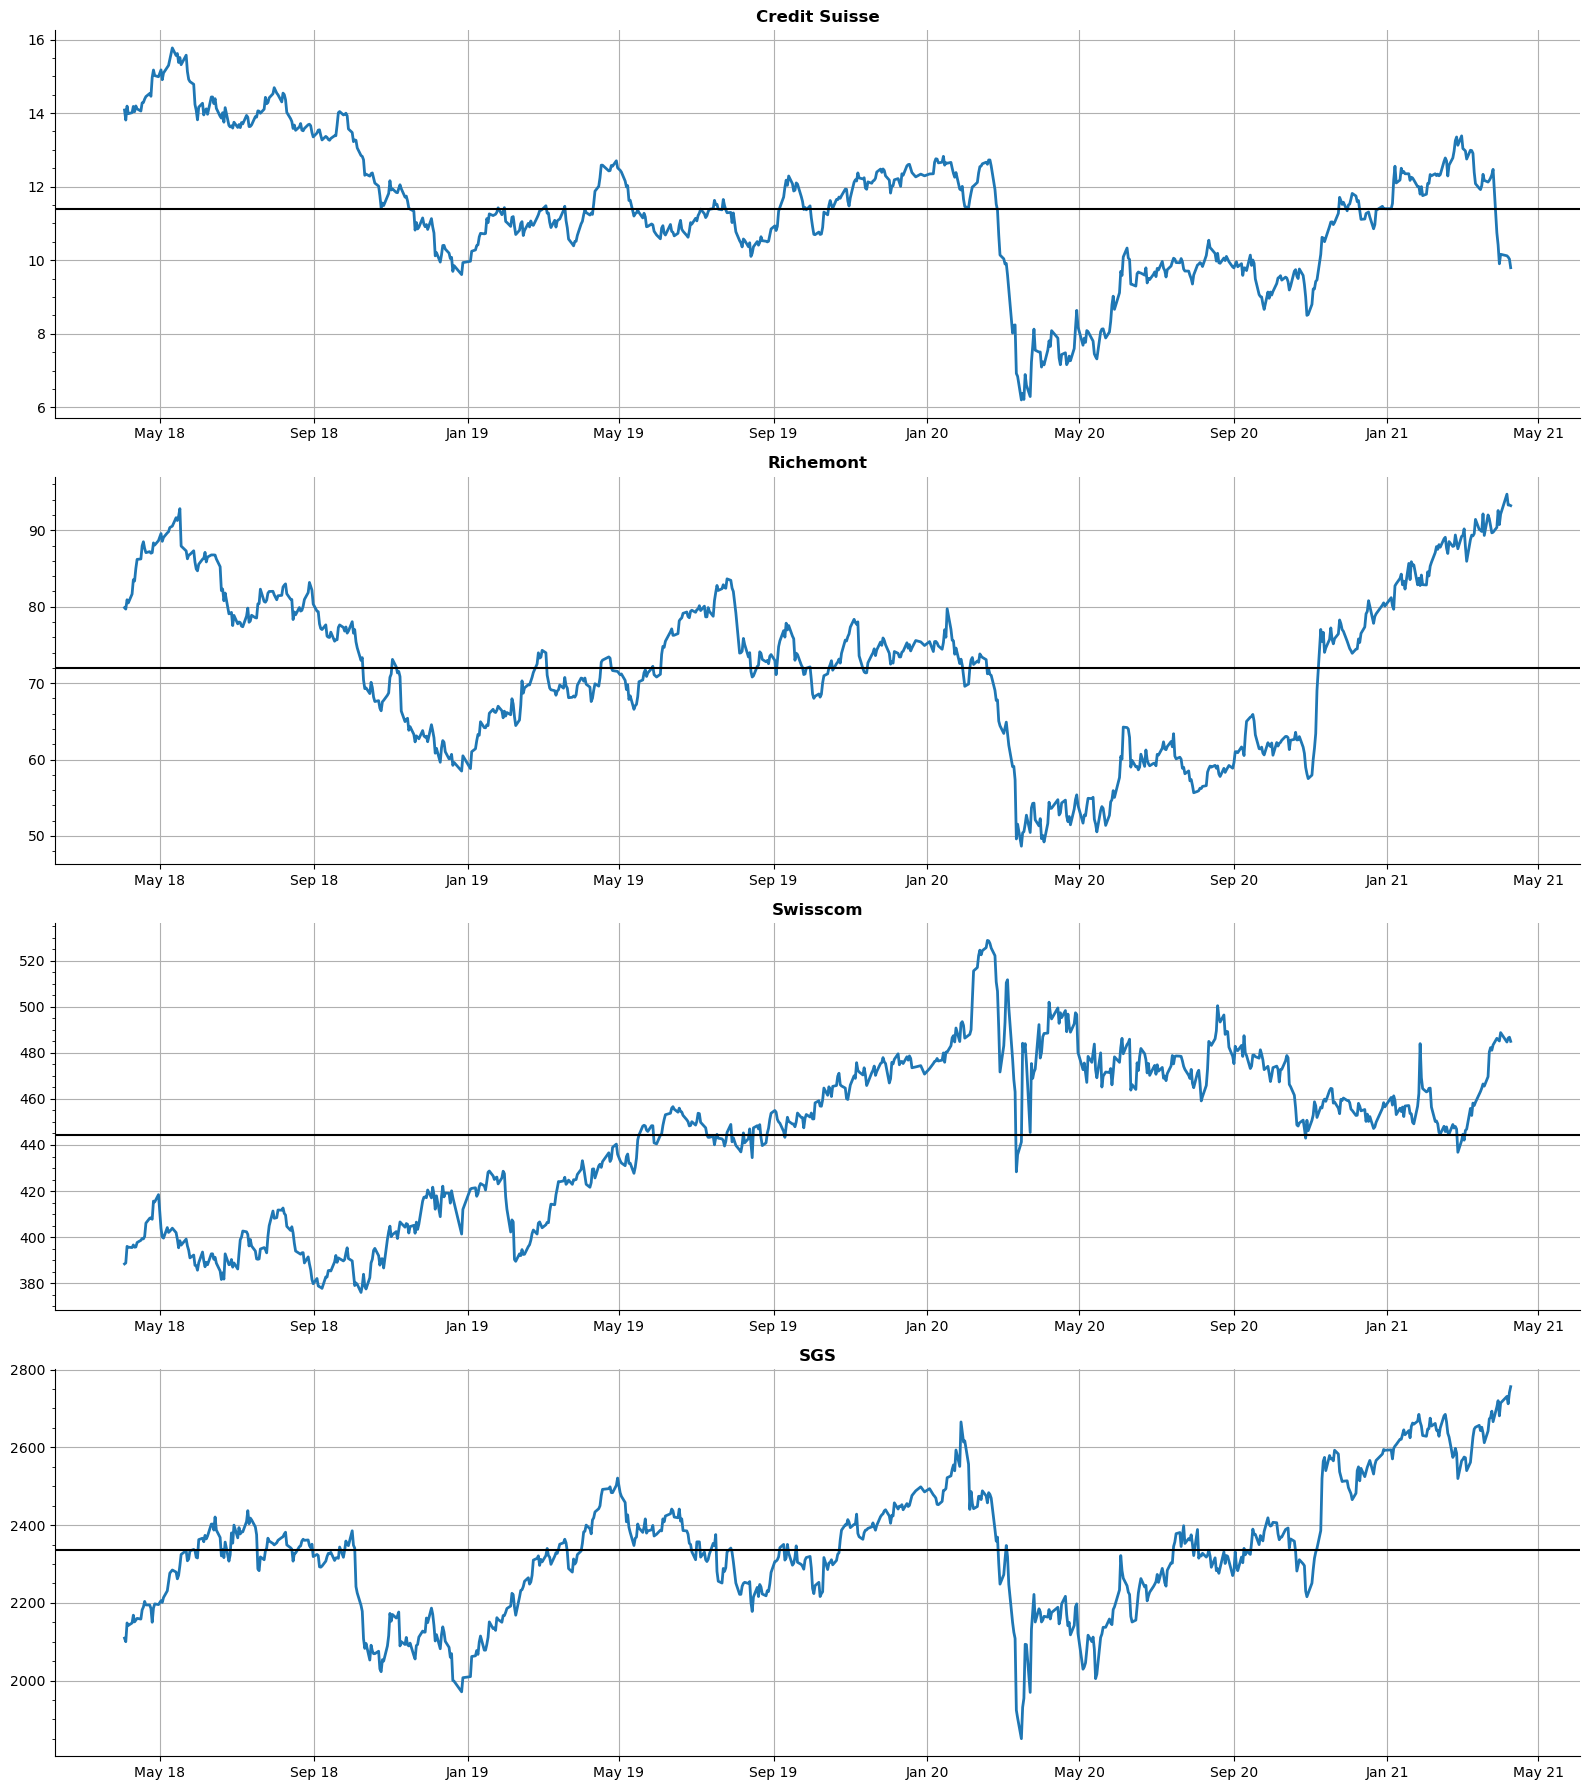

In [14]:
# Price
tcks = selected_prices.columns
fig, ax = plt.subplots(nrows=len(tcks),ncols=1,
                       figsize=[16,9*2],dpi=100)
for i in range(len(tcks)):
    ax[i].plot(selected_prices.iloc[:,i],lw=2)
    ax[i].axhline(selected_prices.iloc[:,i].mean(),c='k')
    ax[i].set_title(tcks[i],fontweight='bold')

    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())    
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].grid()
plt.tight_layout()

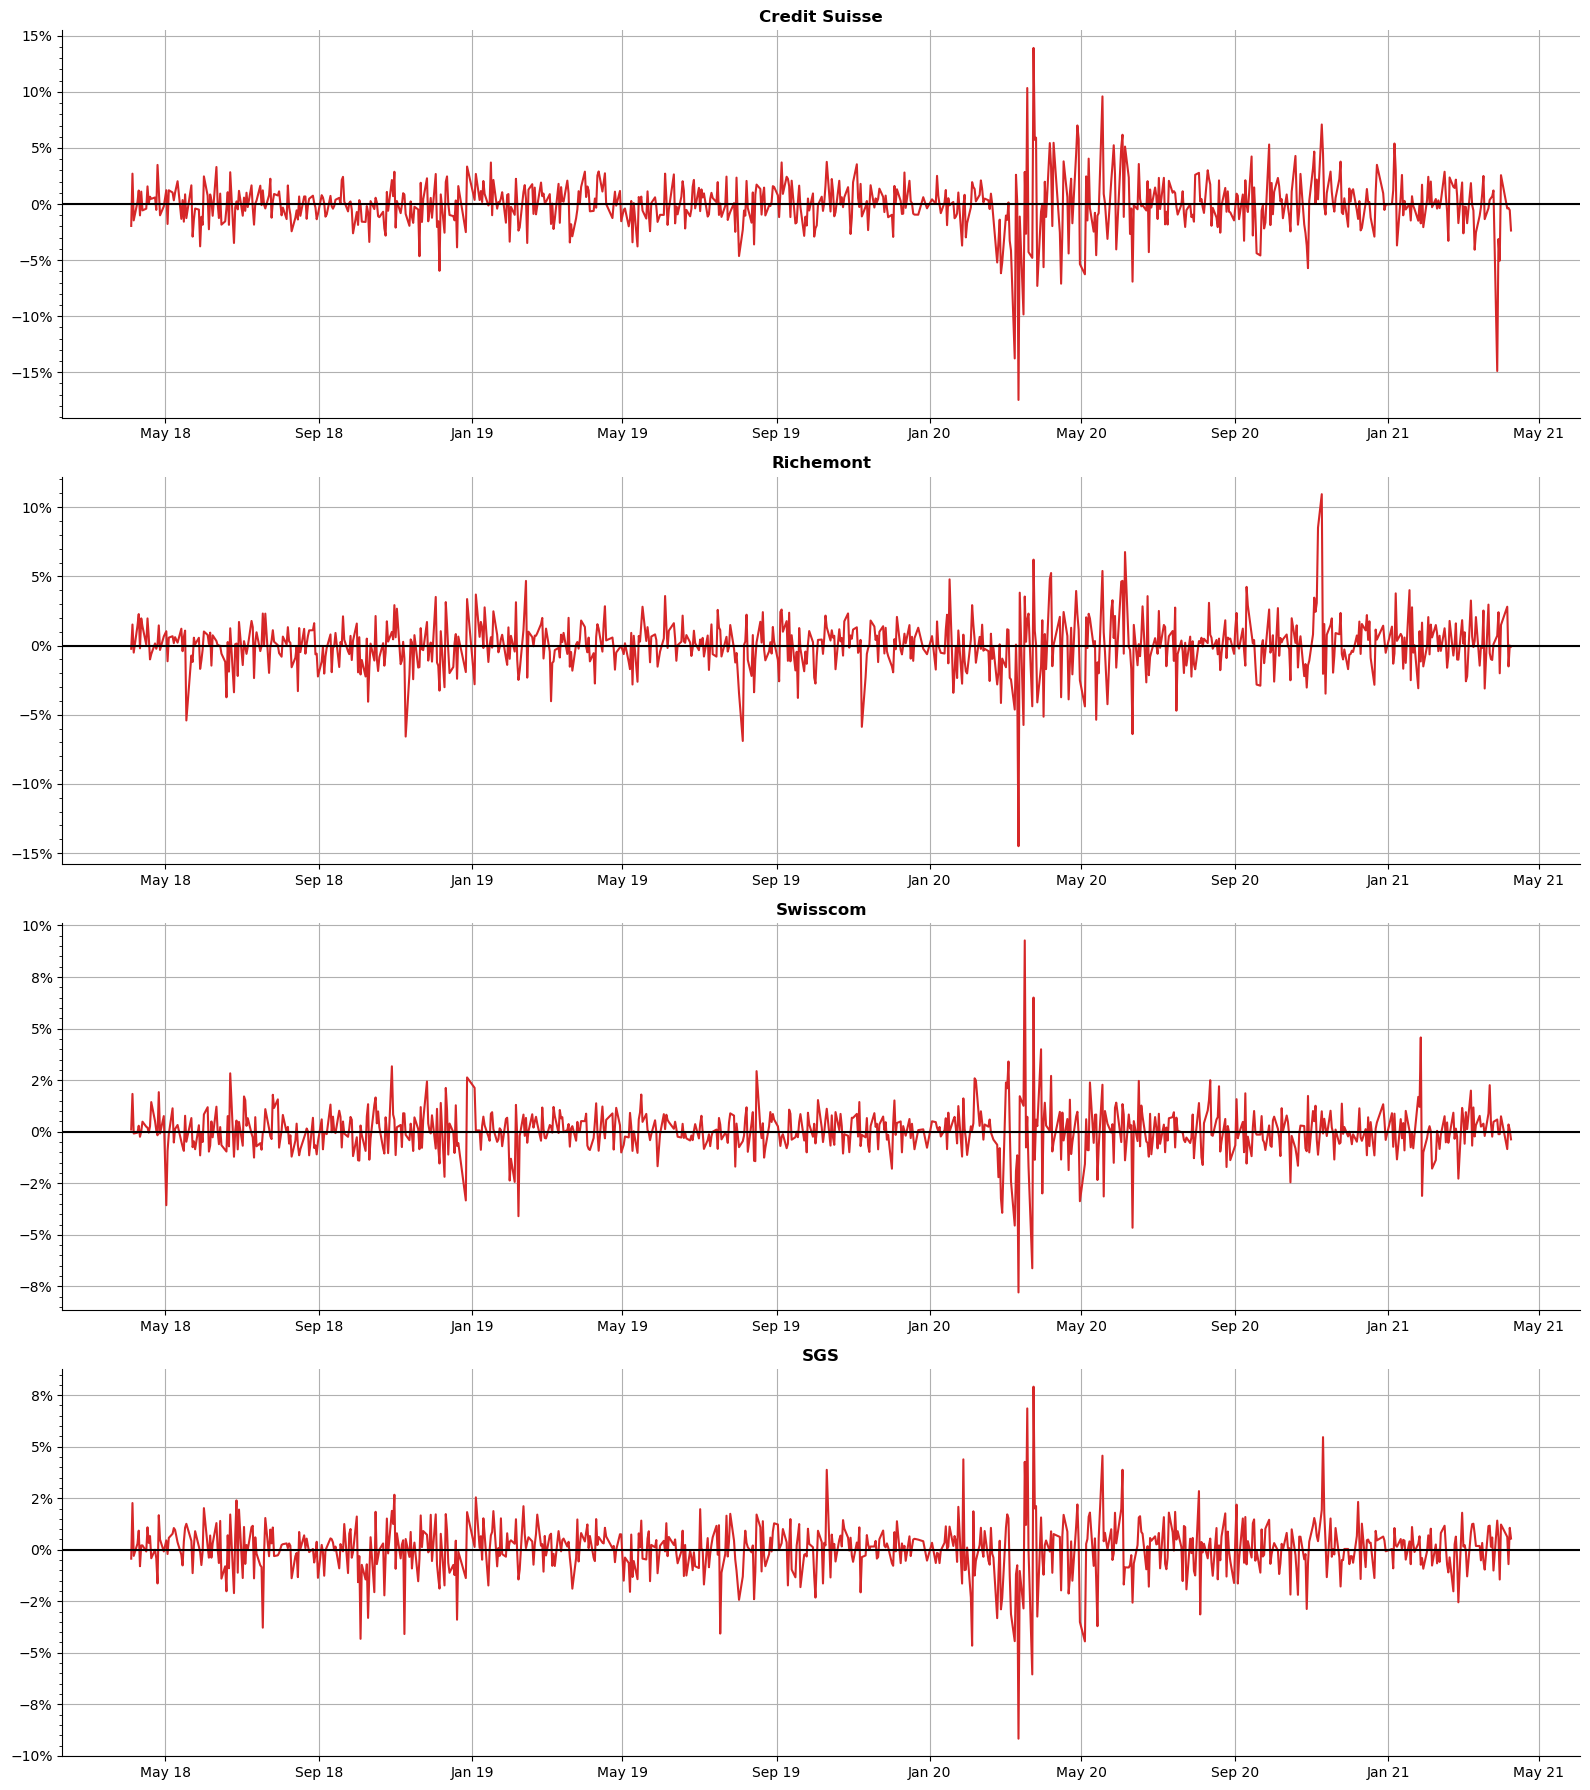

In [15]:
# Returns
tcks = selected_prices.columns
fig, ax = plt.subplots(nrows=len(tcks),ncols=1,
                       figsize=[16,9*2],dpi=100)
for i in range(len(tcks)):
    ax[i].plot(selected_logs.iloc[:,i]*100,c='C3')
    ax[i].axhline(y=0,c='k')
    ax[i].set_title(tcks[i],fontweight='bold')

    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())    
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
    ax[i].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].grid()
plt.tight_layout()

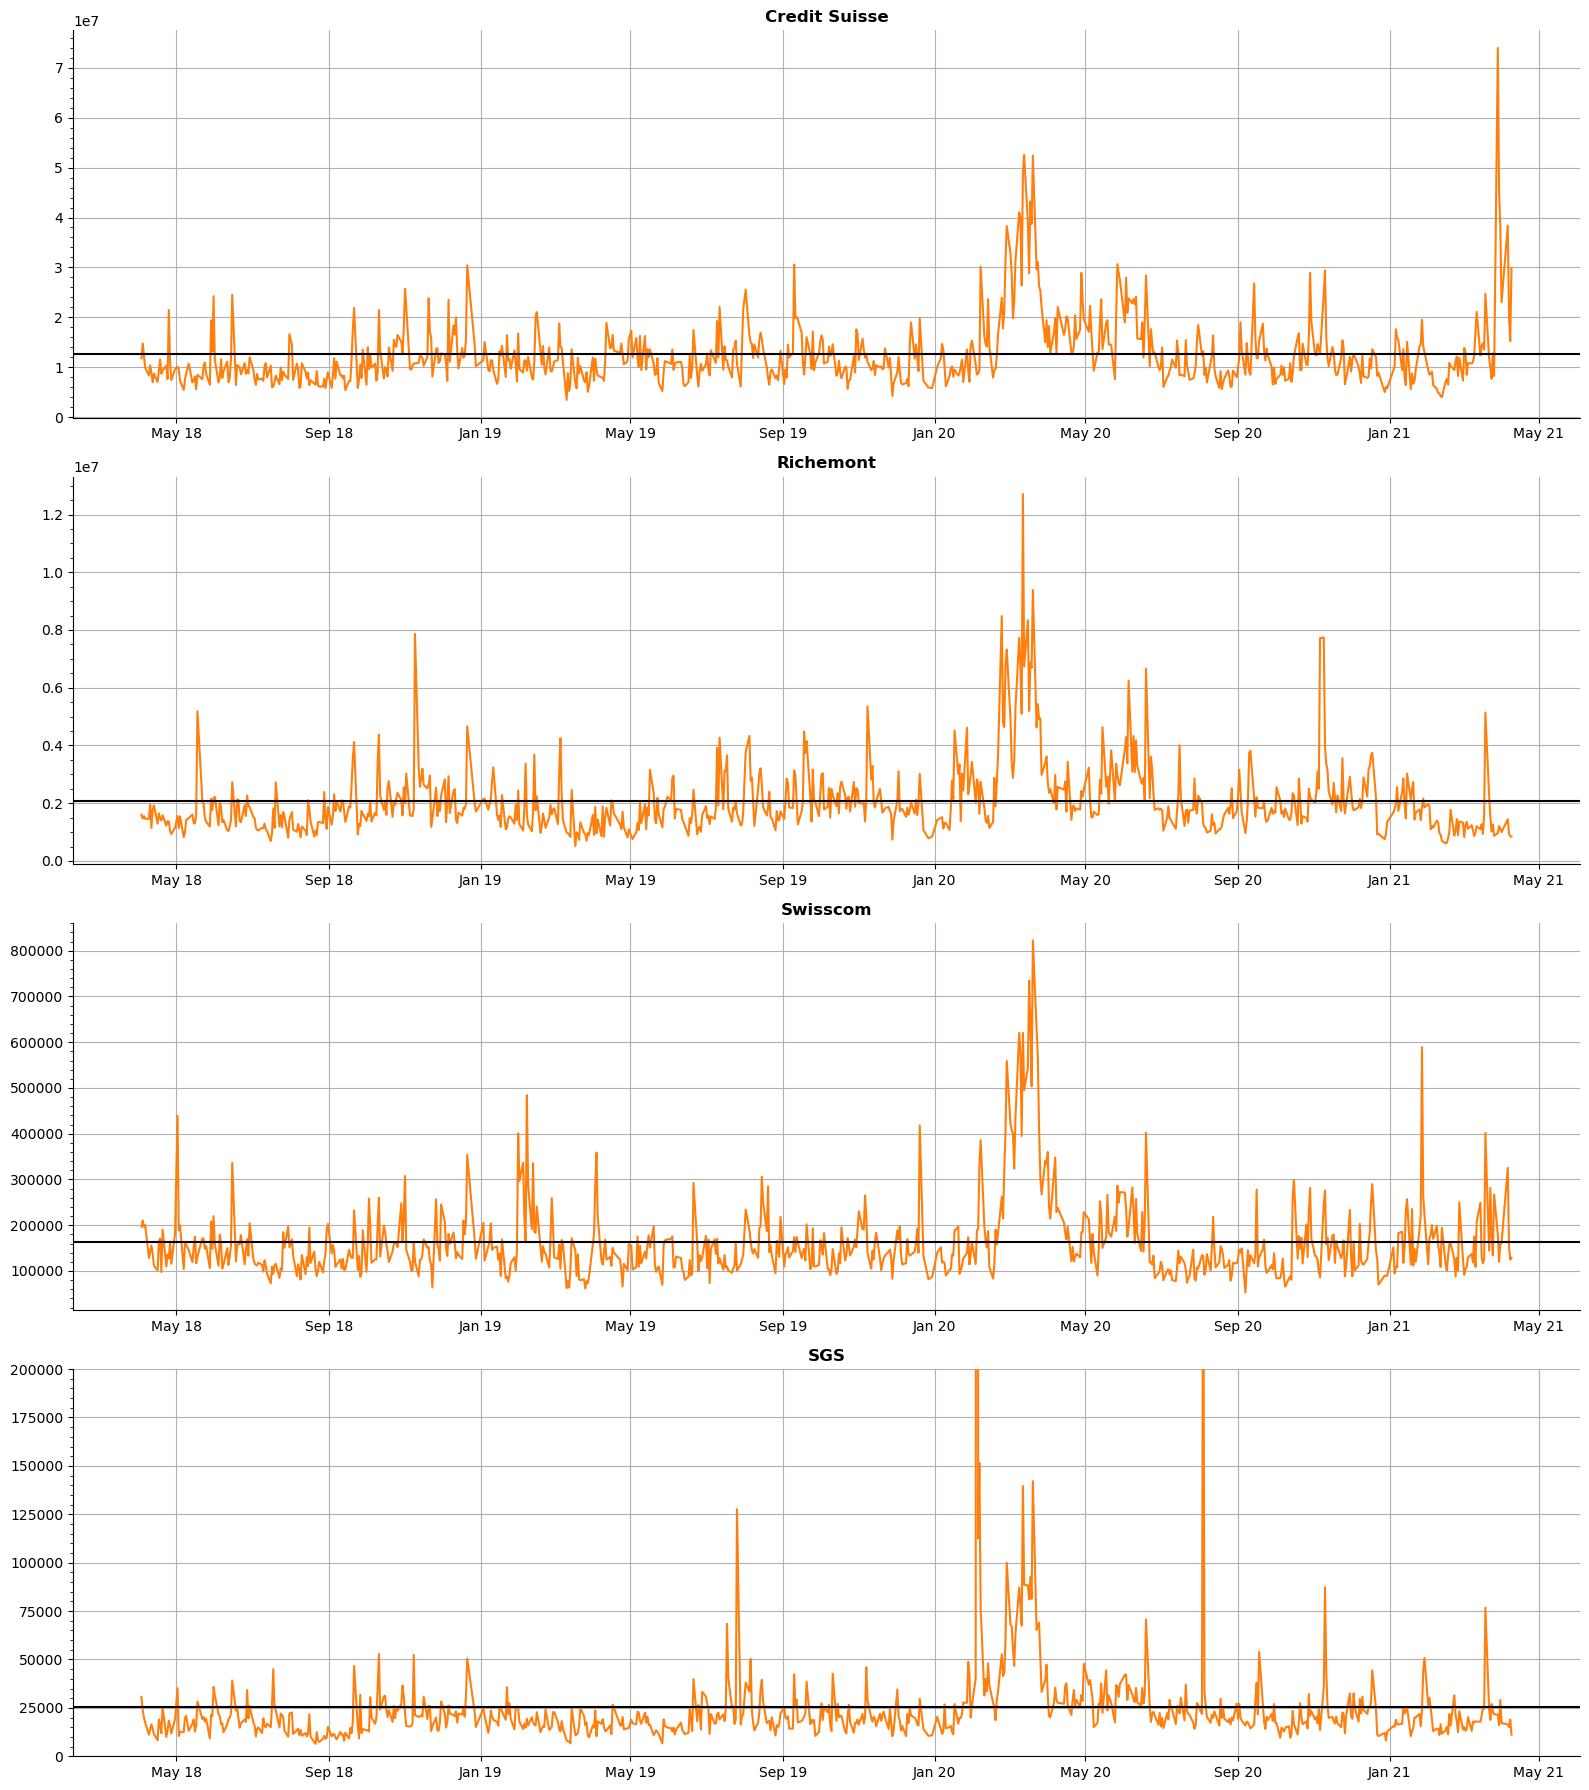

In [16]:
# Price
tcks = selected_vols.columns
fig, ax = plt.subplots(nrows=len(tcks),ncols=1,
                       figsize=[16,9*2],dpi=100)
for i in range(len(tcks)):
    ax[i].plot(selected_vols.iloc[:,i],c='C1')
    ax[i].axhline(selected_vols.iloc[:,i].mean(),c='k')
    ax[i].set_title(tcks[i],fontweight='bold')
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    ax[3].set_ylim([0,200000])

    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())    
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].grid()
plt.tight_layout()

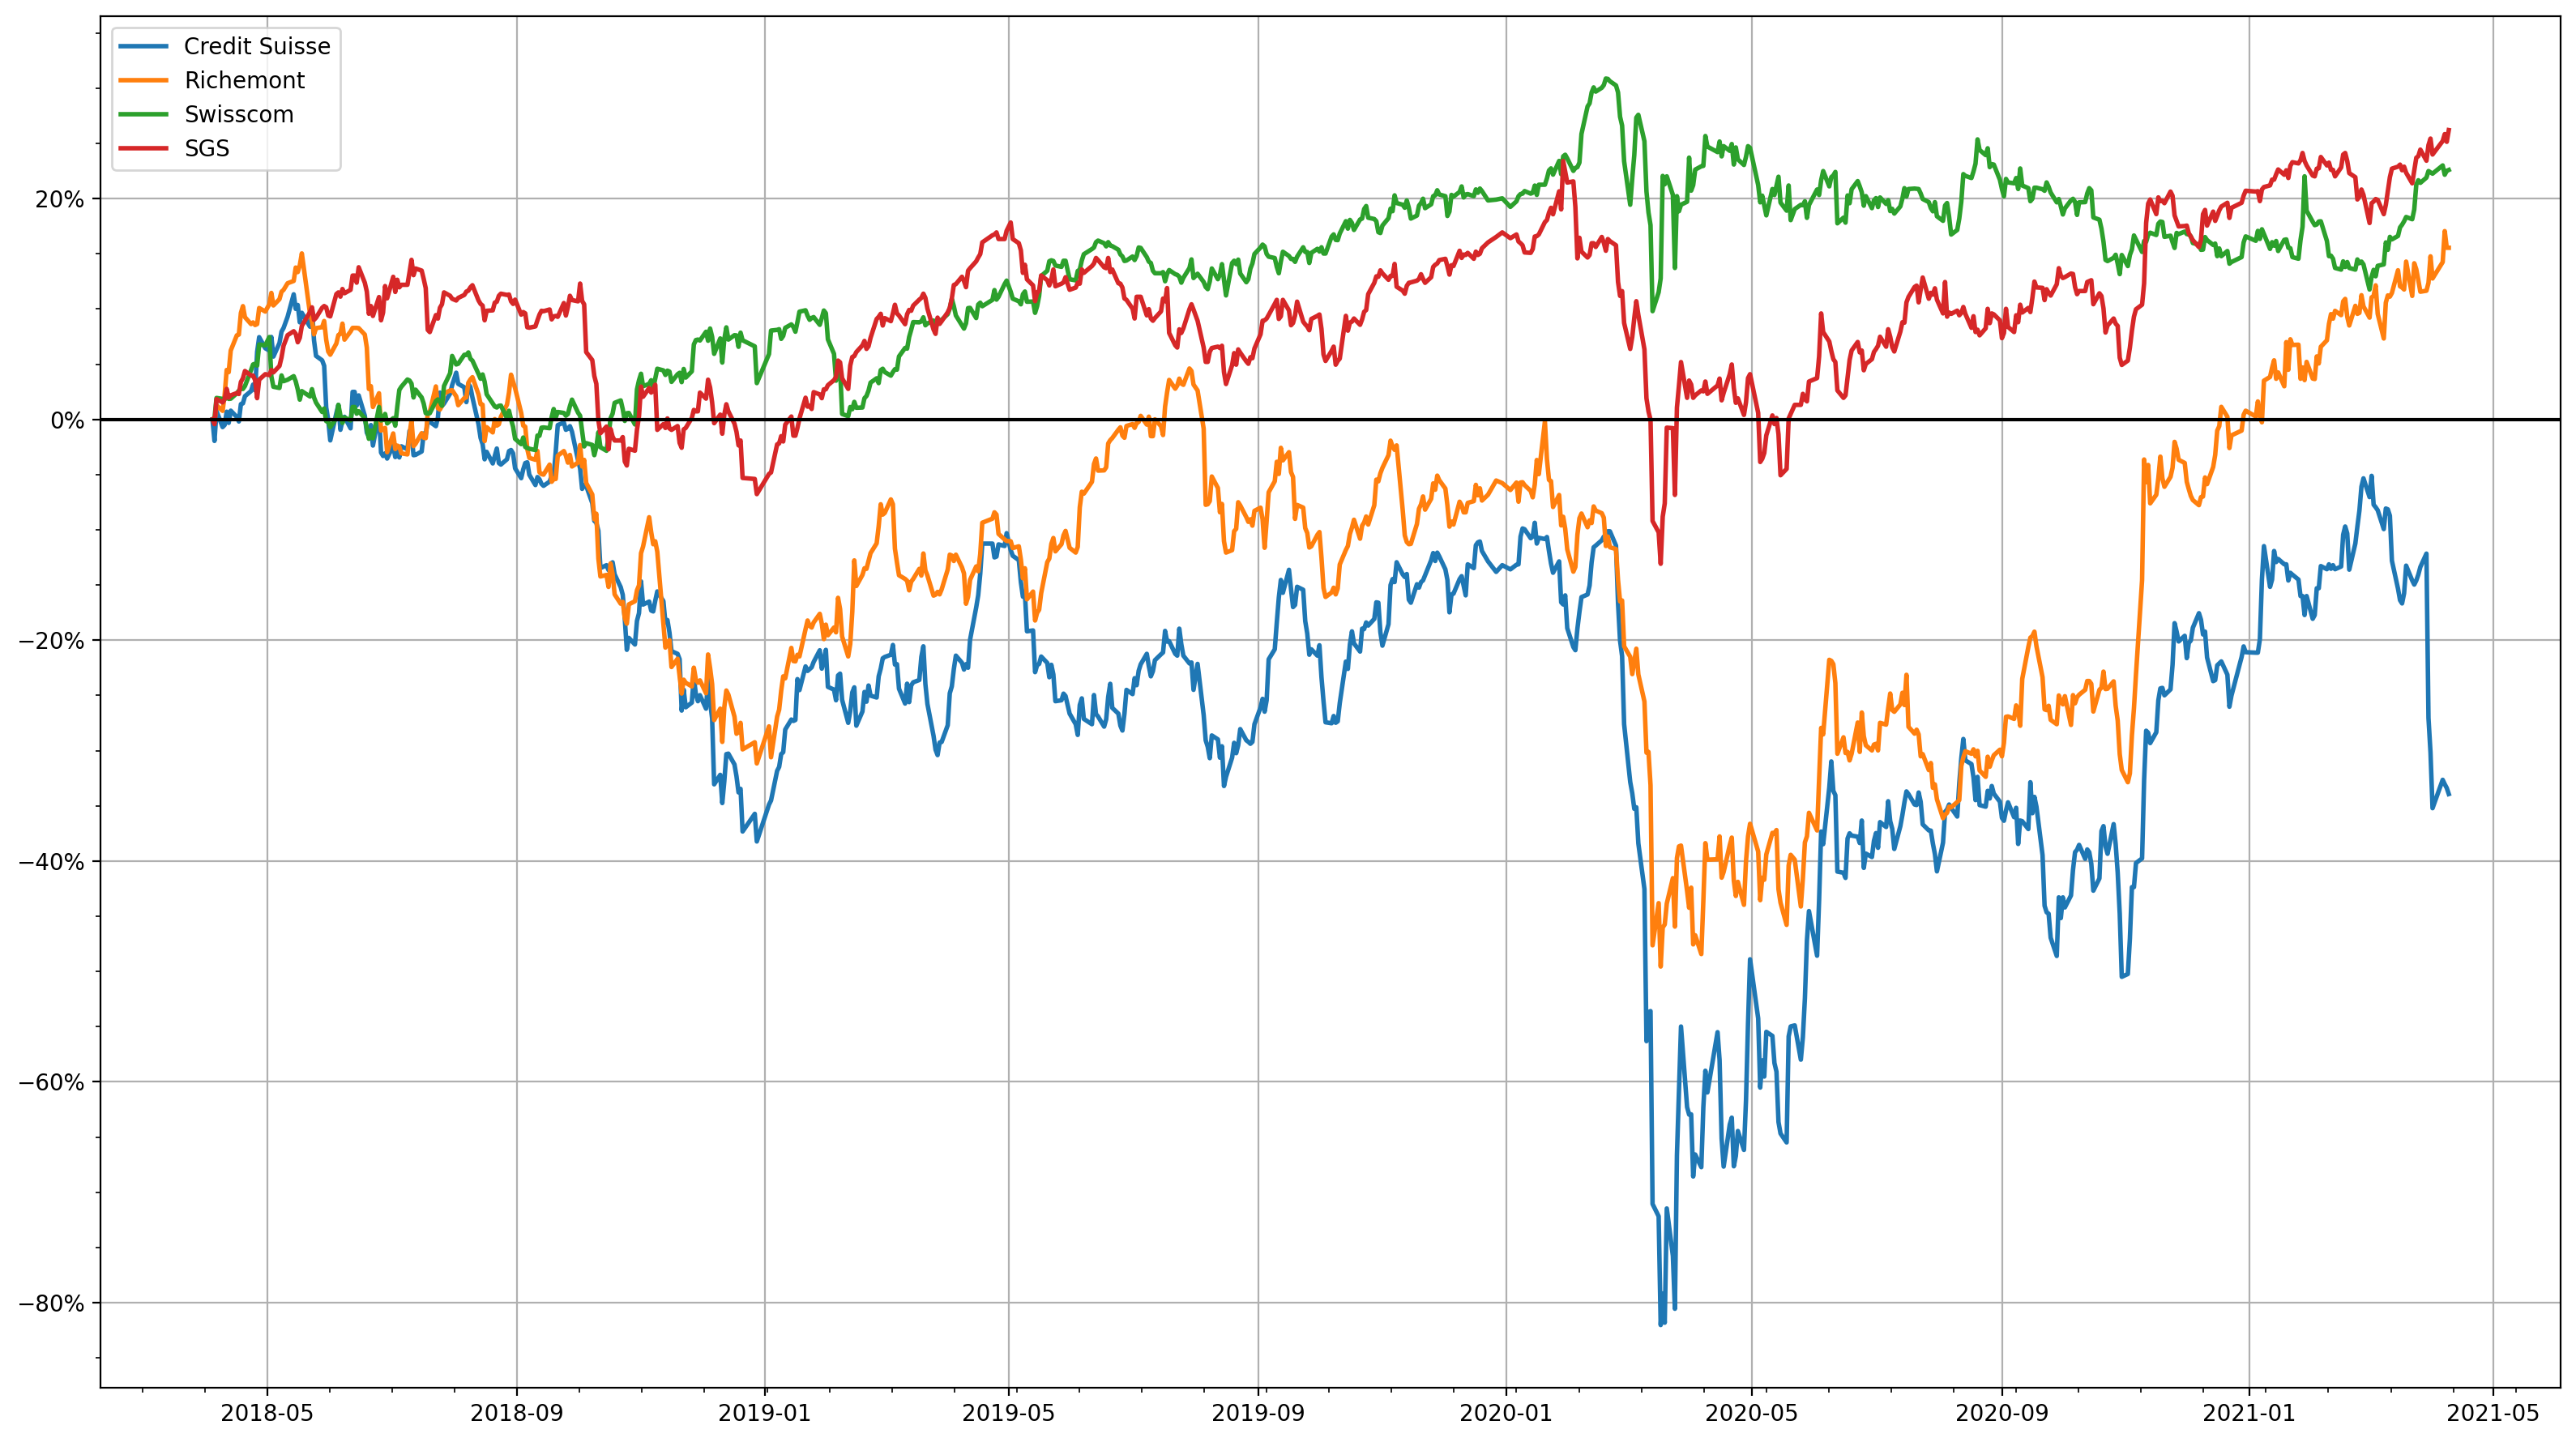

In [17]:
fig, ax = plt.subplots(1,1,figsize=[16,9],dpi=200)

for i in range(4):
    ax.plot(
        compounded(selected_logs.iloc[:,i]*100),
        lw=2
    )
ax.axhline(y=0,color='k')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

ax.grid()
ax.legend(selected)
plt.tight_layout()

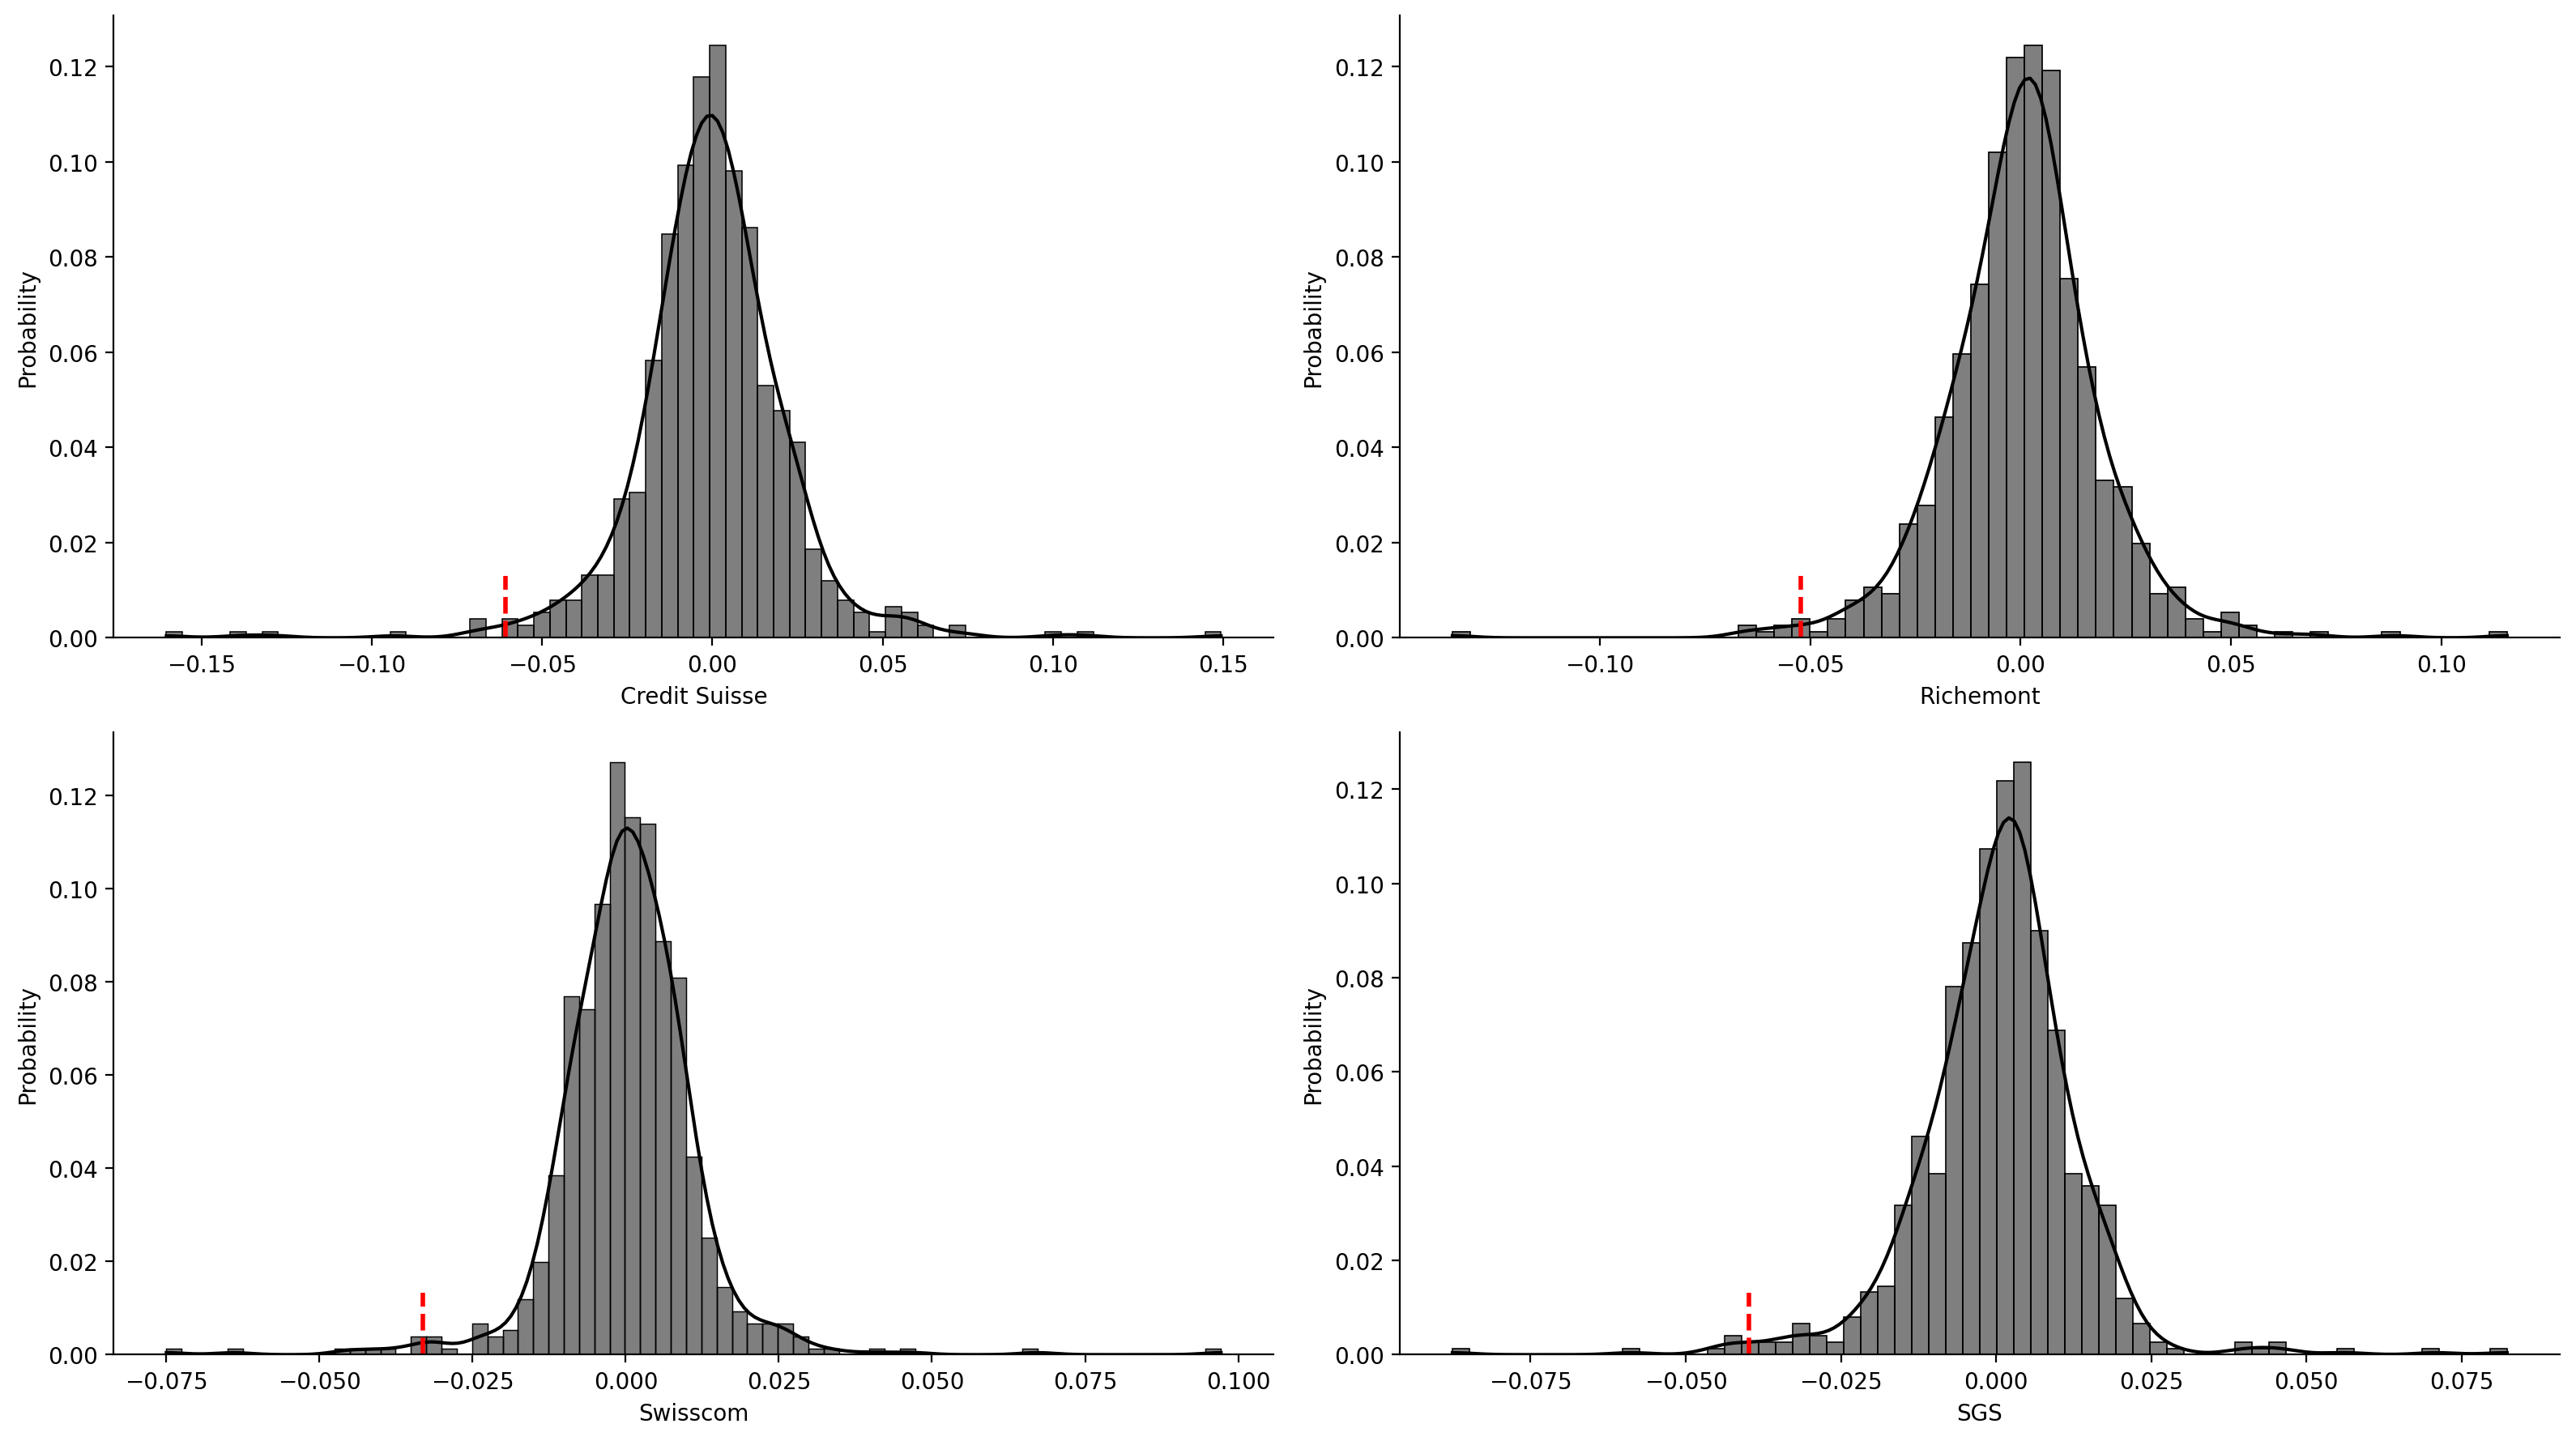

In [18]:
fig, ax = plt.subplots(2,2,figsize=[16,9],dpi=200)

sns.histplot(ax=ax[0,0],
             data=cs_returns,
             kde=True,
             stat='probability',
             color='k')
ax[0,0].axvline(-value_at_risk(cs_returns,0.01),
               ymin=0,ymax=0.1,
               ls='--',c='r',lw=2)

sns.histplot(ax=ax[0,1],
             data=rich_returns,
             kde=True,
             stat='probability',
             color='k')
ax[0,1].axvline(-value_at_risk(rich_returns,0.01),
               ymin=0,ymax=0.1,
               ls='--',c='r',lw=2)

sns.histplot(ax=ax[1,0],
             data=scom_returns,
             kde=True,
             stat='probability',
             color='k')
ax[1,0].axvline(-value_at_risk(scom_returns,0.01),
               ymin=0,ymax=0.1,
               ls='--',c='r',lw=2)

sns.histplot(ax=ax[1,1],
             data=sgs_returns,
             kde=True,
             stat='probability',
             color='k')
ax[1,1].axvline(-value_at_risk(sgs_returns,0.01),
               ymin=0,ymax=0.1,
               ls='--',c='r',lw=2)

sns.despine()
plt.tight_layout()

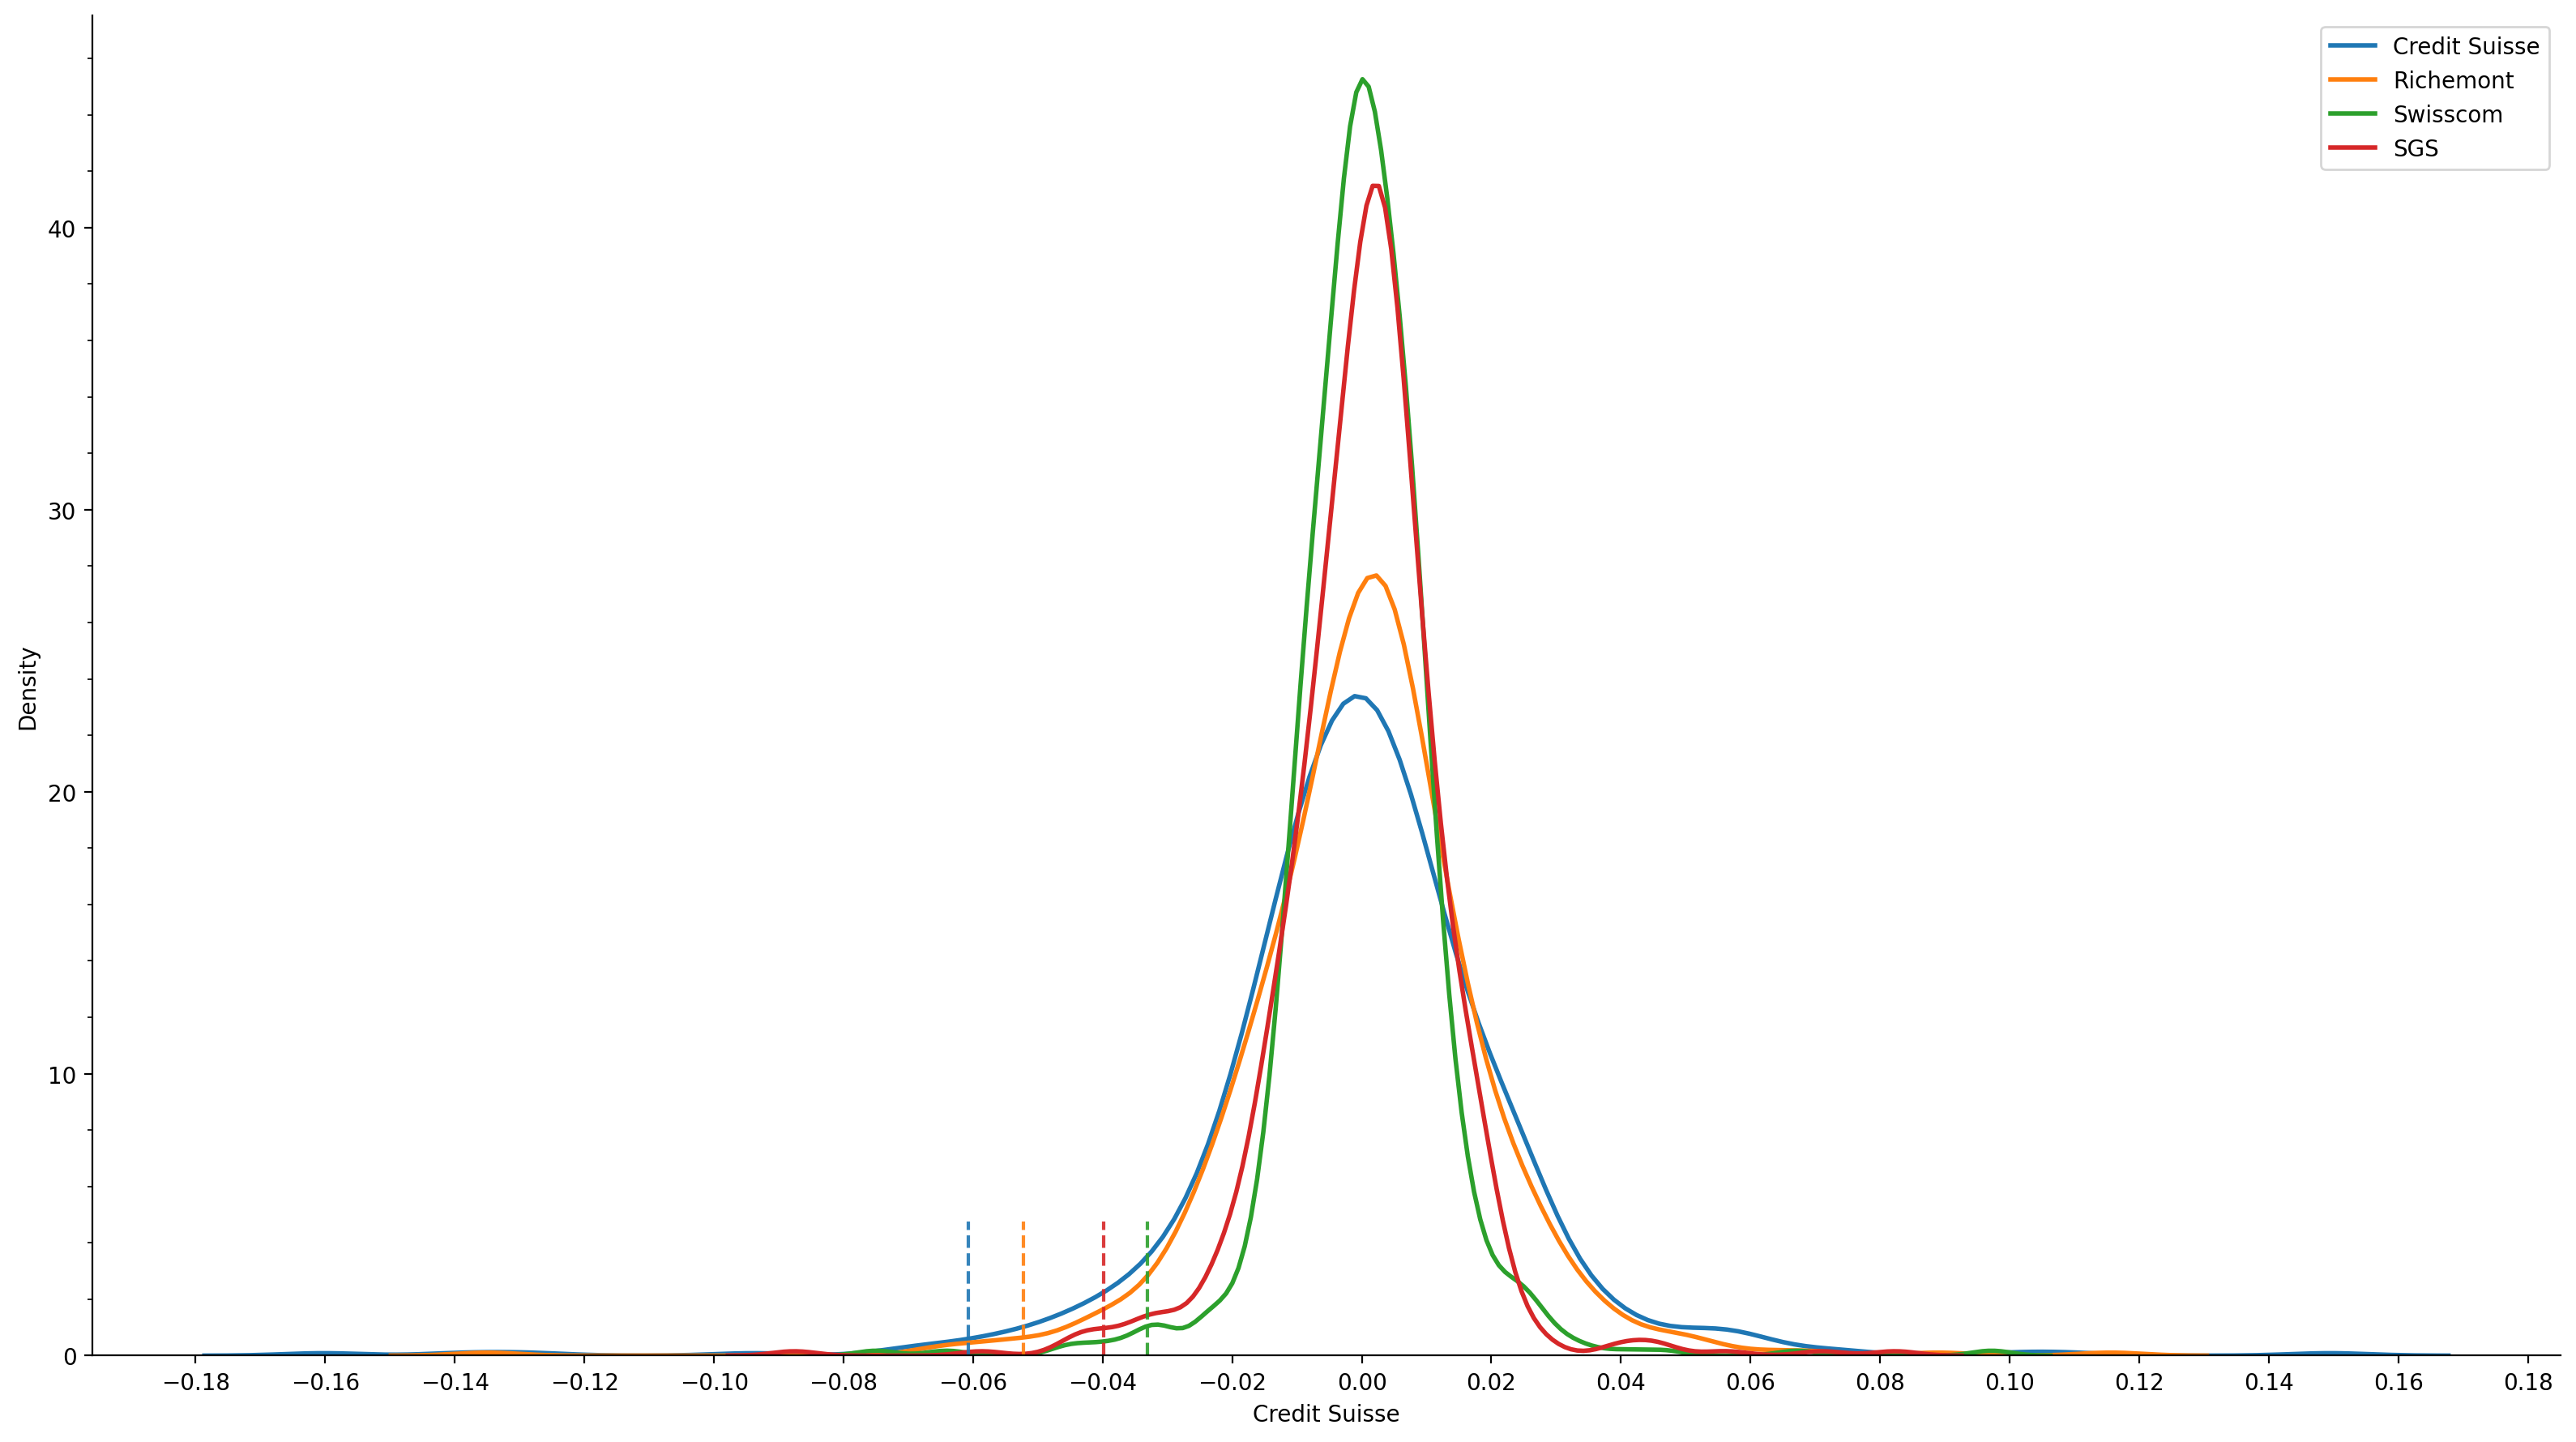

In [19]:
fig, ax = plt.subplots(1,1,figsize=[16,9],dpi=200)

sns.kdeplot(cs_returns,lw=2)
sns.kdeplot(rich_returns,lw=2)
sns.kdeplot(scom_returns,lw=2)
sns.kdeplot(sgs_returns,lw=2)

ax.axvline(-value_at_risk(cs_returns,0.01),
           ymin=0,ymax=0.1,
           ls='--',c='C0',
           lw=1.5,alpha=0.9)
ax.axvline(-value_at_risk(rich_returns,0.01),
           ymin=0,ymax=0.1,
           ls='--',c='C1',
           lw=1.5,alpha=0.9)
ax.axvline(-value_at_risk(scom_returns,0.01),
           ymin=0,ymax=0.1,
           ls='--',c='C2',
           lw=1.5,alpha=0.9)
ax.axvline(-value_at_risk(sgs_returns,0.01),
           ymin=0,ymax=0.1,
           ls='--',c='C3',
           lw=1.5,alpha=0.9)

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

sns.despine()
plt.legend(selected)

plt.tight_layout()

In [20]:
moments = []
for i in range(4):
    fm = four_moments(selected_prices.iloc[:,i],smi20_prices)
    moments.append(fm)
pd.DataFrame(moments,index=selected,columns=['Correlation','Coskewness','Cokurtosis']).round(2)

,Correlation,Coskewness,Cokurtosis
Credit Suisse,-0.17,0.31,-0.08
Richemont,0.12,0.34,0.51
Swisscom,0.78,-0.13,1.37
SGS,0.72,0.19,1.54


In [21]:
moments = []
for i in range(4):
    fm = four_moments(selected_returns.iloc[:,i],smi20_returns)
    moments.append(fm)
pd.DataFrame(moments,index=selected,columns=['Correlation','Coskewness','Cokurtosis']).round(2)

,Correlation,Coskewness,Cokurtosis
Credit Suisse,NaN,NaN,NaN
Richemont,NaN,NaN,NaN
Swisscom,NaN,NaN,NaN
SGS,NaN,NaN,NaN


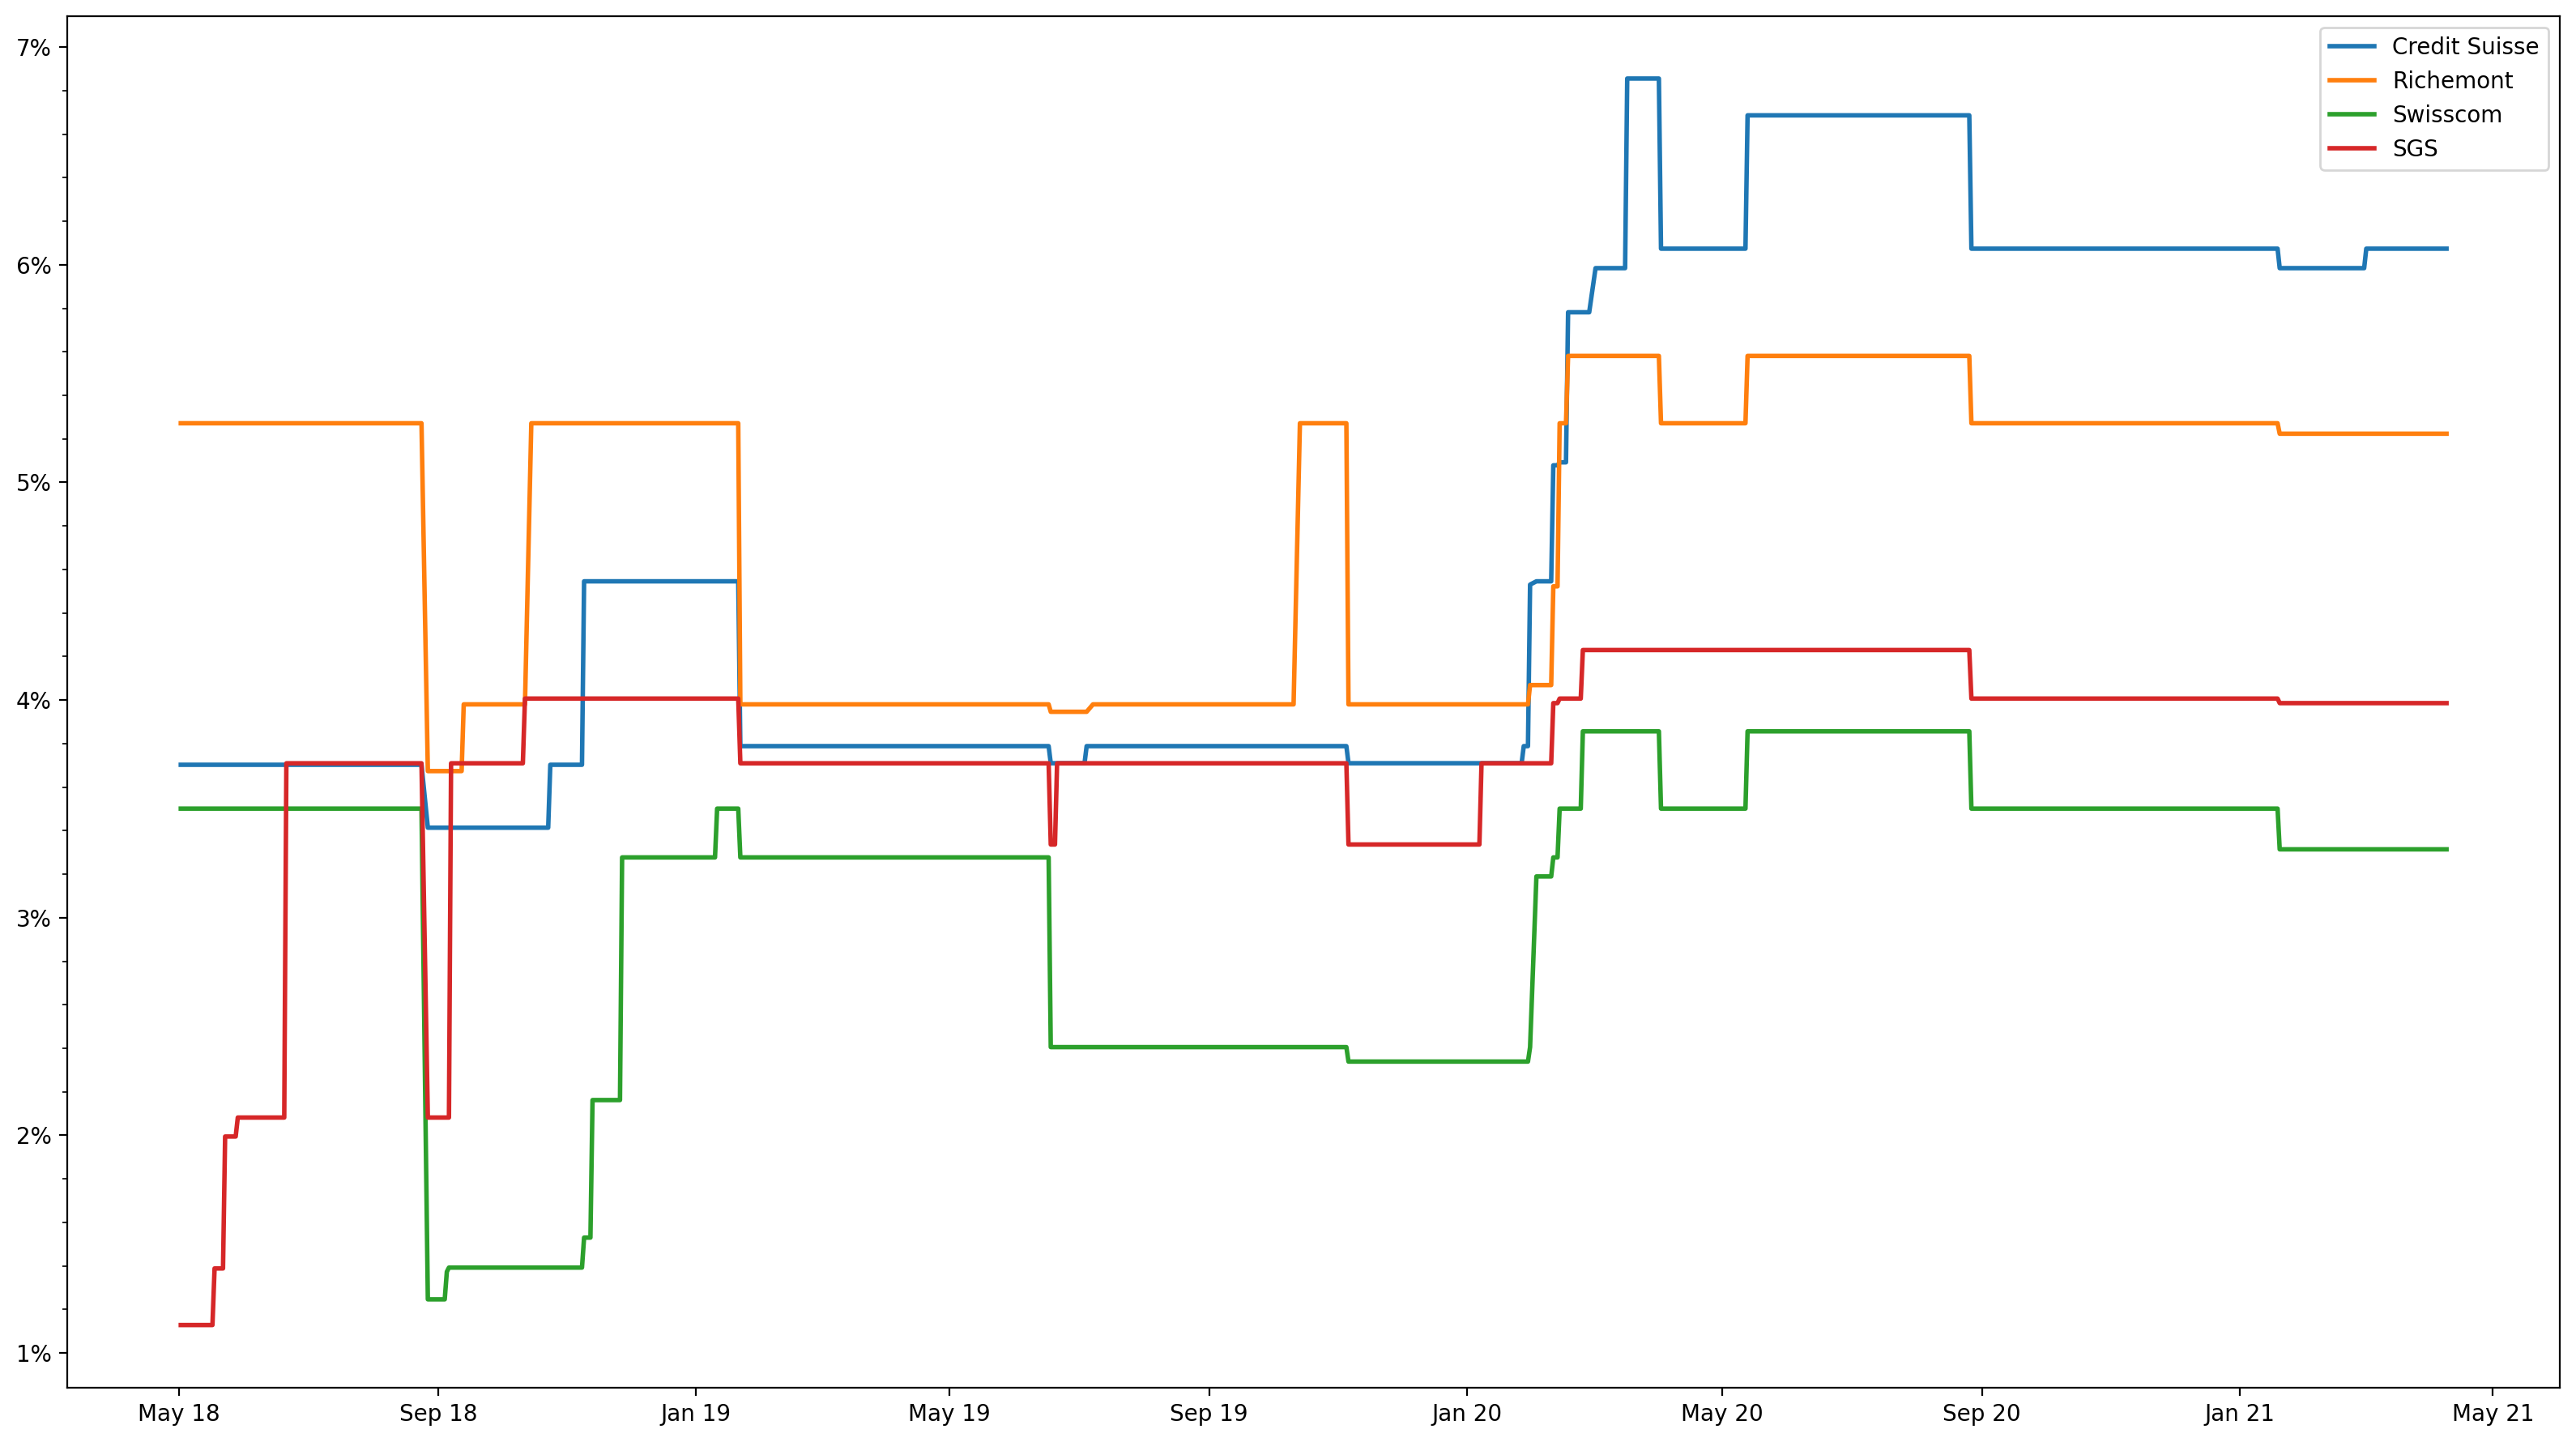

In [22]:
fig, ax = plt.subplots(1,1,figsize=[16,9],dpi=200)

for i in range(4):
    ax.plot(
        VaR_series(selected_returns.iloc[:,i])*100,lw=2
    )

ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.xaxis.set_major_locator(mdates.AutoDateLocator())    
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

ax.legend(selected)

plt.tight_layout()

### Returns compounded

In [23]:
# Parameters
alpha = 0.25
epsilon = 0.01
delta = 10

In [82]:
td_year = 252 # No of trading days in a year

def contract_sel_plot(contract_starts_date,contract_days):

    start_date = datetime.datetime(contract_starts_date[0],
                                   contract_starts_date[1],
                                   contract_starts_date[2])
    end_date = contract_starts_date+pd.tseries.offsets.BDay(contract_days) 

    h1_cs = 1-LV(cs_logs[:start_date],alpha,epsilon,delta)
    h1_rich = 1-LV(rich_logs[:start_date],alpha,epsilon,delta)
    h1_scom = 1-LV(scom_logs[:start_date],alpha,epsilon,delta)
    h1_sgs = 1-LV(sgs_logs[:start_date],alpha,epsilon,delta)


    fig, ax = plt.subplots(2,2,
                           figsize=[16,9],dpi=100)

    ax[0,0].plot(compounded_date(cs_logs,start_date,end_date))
    ax[0,0].axhline(y=-h1_cs)
    ax[0,0].set_title(selected[0],fontweight='bold')

    ax[0,1].plot(compounded_date(rich_logs,start_date,end_date))
    ax[0,1].axhline(y=-h1_rich)
    ax[0,1].set_title(selected[1],fontweight='bold')

    ax[1,0].plot(compounded_date(scom_logs,start_date,end_date))
    ax[1,0].axhline(y=-h1_scom)
    ax[1,0].set_title(selected[2],fontweight='bold')

    ax[1,1].plot(compounded_date(sgs_logs,start_date,end_date))
    ax[1,1].axhline(y=-h1_sgs)
    ax[1,1].set_title(selected[3],fontweight='bold')

    for i in range(2):
        for j in range(2):
            ax[i,j].yaxis.set_minor_locator(ticker.AutoMinorLocator())
            ax[i,j].xaxis.set_major_locator(mdates.AutoDateLocator())    
            ax[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
            ax[i,j].spines['right'].set_visible(False)
            ax[i,j].spines['top'].set_visible(False)
            ax[i,j].grid()
    plt.tight_layout()

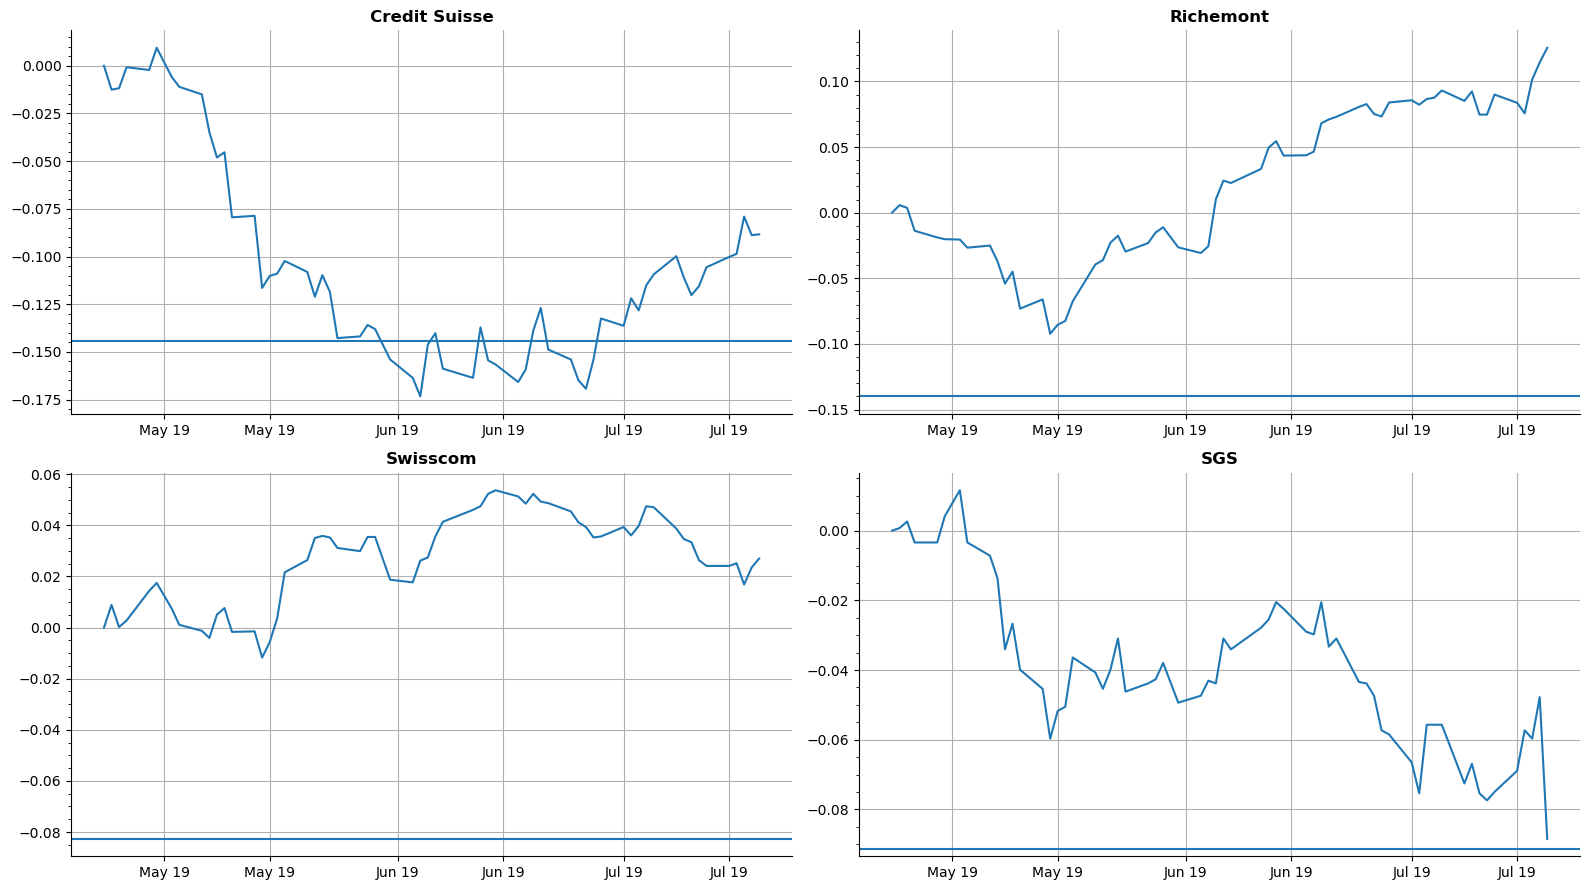

In [99]:
contract_sel_plot([2019, 4, 23],td_year/4)

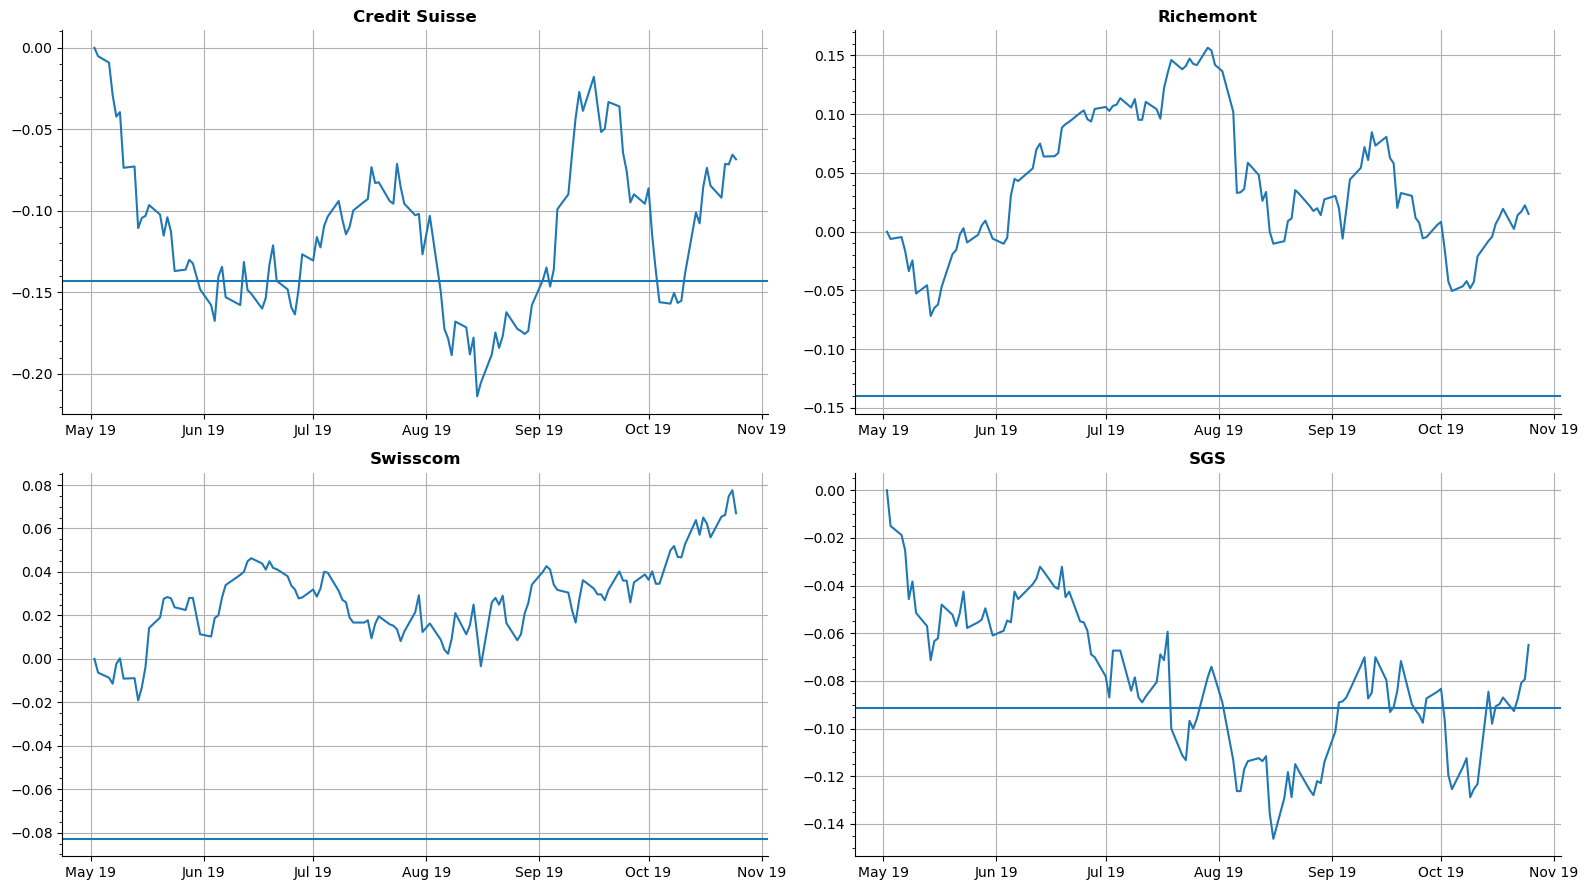

In [100]:
contract_sel_plot([2019, 5, 2],td_year/2)

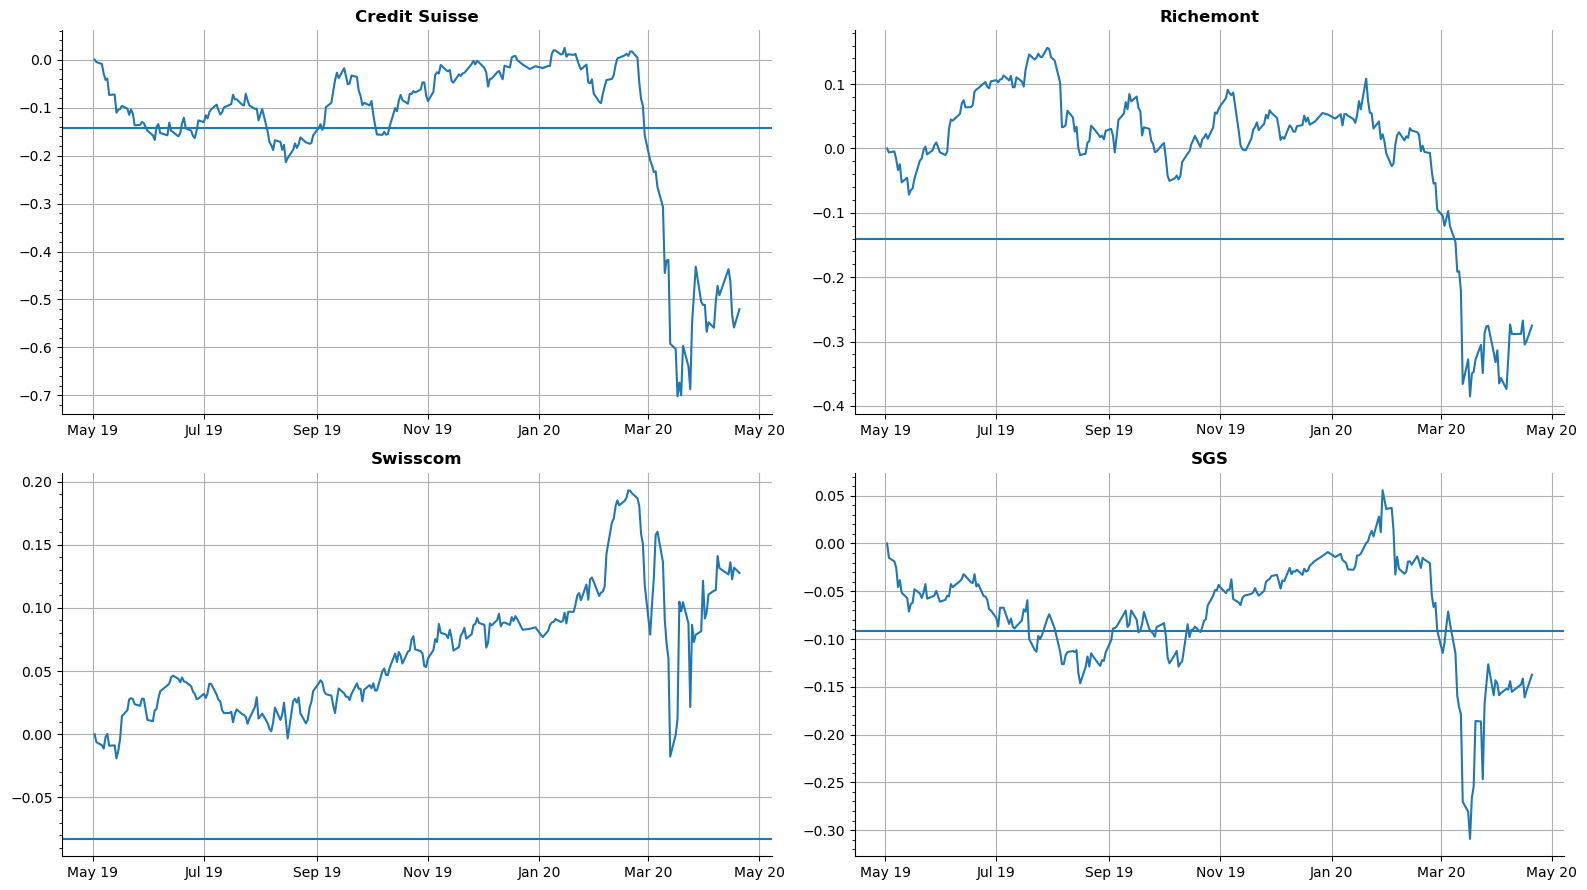

In [101]:
contract_sel_plot([2019, 5, 2],td_year)

In [107]:
def margincall_days(logs,contract_starts_date,contract_days):
    start_date = datetime.datetime(contract_starts_date[0],
                                   contract_starts_date[1],
                                   contract_starts_date[2])
    end_date = start_date+pd.tseries.offsets.BDay(contract_days) 
    
    lv = LV(logs[:start_date],alpha,epsilon,delta)
    haircut = 1-lv
    comp = compounded_date(logs,start_date,end_date)
    mcstate = comp[comp<(-haircut)]
    mcstate_dates = len(mcstate)
    freq = mcstate_dates / len(logs[start_date:end_date])
    return comp,mcstate,mcstate_dates, freq

In [133]:
margincall_days(cs_logs,[2019,5,2],62)[1][0:1].index[0]

Timestamp('2019-05-31 00:00:00')

In [134]:
margincall_days(cs_logs,[2019,5,2],62)[1][0:1].index[0] + pd.tseries.offsets.BDay(10) 

Timestamp('2019-06-14 00:00:00')

In [135]:
margincall_days(cs_logs,[2019,5,2],62)[1]

Date
2019-05-31   -0.148131
2019-06-03   -0.157742
2019-06-04   -0.167447
2019-06-07   -0.152925
2019-06-11   -0.157742
2019-06-13   -0.148566
2019-06-14   -0.150743
2019-06-17   -0.159939
2019-06-18   -0.153362
2019-06-24   -0.148131
2019-06-25   -0.159060
2019-06-26   -0.163465
2019-06-27   -0.148131
dtype: float64

In [108]:
margincall_days(cs_logs,[2019,5,2],62)

(Date
 2019-05-02    0.000000
 2019-05-03   -0.005160
 2019-05-06   -0.009125
 2019-05-07   -0.028996
 2019-05-08   -0.042205
                 ...   
 2019-07-23   -0.095621
 2019-07-24   -0.071170
 2019-07-25   -0.085360
 2019-07-26   -0.095621
 2019-07-29   -0.102659
 Length: 61, dtype: float64,
 Date
 2019-05-31   -0.148131
 2019-06-03   -0.157742
 2019-06-04   -0.167447
 2019-06-07   -0.152925
 2019-06-11   -0.157742
 2019-06-13   -0.148566
 2019-06-14   -0.150743
 2019-06-17   -0.159939
 2019-06-18   -0.153362
 2019-06-24   -0.148131
 2019-06-25   -0.159060
 2019-06-26   -0.163465
 2019-06-27   -0.148131
 dtype: float64,
 13,
 0.21311475409836064)

In [33]:
cs_logs['2019-05-02':'2019-08-02']

Date
2019-05-02   -0.005160
2019-05-03   -0.003965
2019-05-06   -0.019871
2019-05-07   -0.013209
2019-05-08    0.002734
                ...   
2019-07-26   -0.007038
2019-07-29    0.000831
2019-07-30   -0.024796
2019-07-31    0.023550
2019-08-02   -0.046362
Name: Credit Suisse, Length: 64, dtype: float64

In [34]:
margincall_days(cs_logs,'2019-05-02','2019-08-02')

(13, 0.203125)

In [35]:
def margincall(logs,start_date,end_date):
    delta = 10
    td = pd.tseries.offsets.BusinessDay(delta)#datetime.timedelta(delta)
    
    lv = LV(logs[:start_date],alpha,epsilon,delta)
    haircut = 1-lv
    comp = compounded_date(logs,start_date,end_date)
    mcstate = comp[comp<(-haircut)]
    
    mc_start = mcstate.index[0]
    mc_first = comp[mc_start:mc_start+td]
    return mc_first

In [36]:
cs_logs['2019-05-02':'2020-04-30']

Date
2019-05-02   -0.005160
2019-05-03   -0.003965
2019-05-06   -0.019871
2019-05-07   -0.013209
2019-05-08    0.002734
                ...   
2020-04-24   -0.017151
2020-04-27    0.044688
2020-04-28    0.070079
2020-04-29    0.057913
2020-04-30   -0.053548
Name: Credit Suisse, Length: 250, dtype: float64

In [37]:
mcc = margincall(cs_logs,'2019-05-02','2019-08-02')
mcc

Date
2019-05-31   -0.148131
2019-06-03   -0.157742
2019-06-04   -0.167447
2019-06-05   -0.140335
2019-06-06   -0.134314
2019-06-07   -0.152925
2019-06-11   -0.157742
2019-06-12   -0.131316
2019-06-13   -0.148566
2019-06-14   -0.150743
dtype: float64

In [38]:
# if any(mcc>csh1) == True:
# else print('default')

## Lending Value Model

In [39]:
# Parameters
alpha = 0.25
epsilon = 0.01
delta = 10

In [66]:
# Base LV model for smi20
smi_n = len(smi_logs.columns) # number of assets
smi_names = list(smi_logs.columns) # names of firms

smi_lvs = []
for i in range(smi_n):
    lv = LV(smi_logs.iloc[:,i],alpha,epsilon,delta)
    smi_lvs.append(lv*100)
smi_lvs = pd.DataFrame(smi_lvs,index=smi_names)
smi_lvs.columns = ['% Lending Value']

smi_lvs_gbm = pd.concat([smi_lvs,
                         pd.Series((std(smi_logs)/mean(smi_logs))*100,name='% Std'),
                         pd.Series(GBM(smi_logs)[1]*100,name='% Diffusion')],axis=1)\
                    .sort_values('% Lending Value',ascending=False).round(2)
smi_lvs_gbm

,% Lending Value,% Std,% Diffusion
Nestle,90.92,1723.69,0.11
Swisscom,89.80,3880.41,0.13
Givaudan,89.56,1496.16,0.15
Novartis,88.71,3369.65,0.16
Roche,88.65,2189.79,0.17
SGS,88.62,3633.72,0.17
Geberit,88.12,2188.36,0.19
Zurich Insurance Group,86.64,2611.33,0.24
Partners Group,86.48,1732.56,0.26
ABB,85.79,2712.34,0.27


In [43]:
smi_lvs_gbm.loc[selected]

,% Lending Value,% Drift,% Diffusion
Credit Suisse,79.36,-0.75,0.54
Richemont,83.60,0.03,0.35
Swisscom,89.80,0.23,0.13
SGS,88.62,0.27,0.17


## Adjusted for Liquidity

In [44]:
a_hat_juri = -1.87096
b_hat_juri = -0.794554

In [45]:
smi_adtv = ADTV(smi_vols)['ADTV - Last month']
smi_adtv.name = 'ADTV'

smi_gamma = []
for i in smi_adtv:
    est_i = gamma_est(i,a_hat_juri,b_hat_juri)
    smi_gamma.append(est_i)
smi_gamma = pd.Series(smi_gamma,index=smi_names,name='Gamma')

smi_liq = pd.concat([smi_adtv.round(0).astype(int),
                     smi_gamma],
                    axis=1).sort_values('ADTV',ascending=False)
smi_liq

,ADTV,Gamma
Credit Suisse,22595017,1.931434e-08
UBS,14342478,2.771505e-08
ABB,6011701,5.530451e-08
Novartis,5362601,6.056026e-08
Nestle,4911121,6.494349e-08
LafargeHolcim,1969625,1.342185e-07
Roche,1687020,1.517948e-07
Richemont,1379817,1.780821e-07
Swiss Re,1261646,1.912122e-07
Alcon,973924,2.348732e-07


In [46]:
smi_liq.loc[selected]

,ADTV,Gamma
Credit Suisse,22595017,1.931434e-08
Richemont,1379817,1.780821e-07
Swisscom,184674,8.802315e-07
SGS,23095,4.591796e-06


In [47]:
smi_adjlvs_x0 = []
smi_adjlvs_xthousand = []
smi_adjlvs_xmil = []
smi_adjlvs_x2adtv = []

for i in range(smi_n):
    adjlv = LV_adj(smi_logs.iloc[:,i],
                   alpha,epsilon,delta,
                   smi_gamma[i],
                  0)
    smi_adjlvs_x0.append(adjlv)

for i in range(smi_n):
    adjlv = LV_adj(smi_logs.iloc[:,i],
                   alpha,epsilon,delta,
                   smi_gamma[i],
                  smi_adtv[i]*2)
    smi_adjlvs_xthousand.append(adjlv)
    
for i in range(smi_n):
    adjlv = LV_adj(smi_logs.iloc[:,i],
                   alpha,epsilon,delta,
                   smi_gamma[i],
                  smi_adtv[i]*2)
    smi_adjlvs_xmil.append(adjlv)
    
for i in range(smi_n):
    adjlv = LV_adj(smi_logs.iloc[:,i],
                   alpha,epsilon,delta,
                   smi_gamma[i],
                  smi_adtv[i]*2)
    smi_adjlvs_x2adtv.append(adjlv)

smi_adjlvs = pd.DataFrame([smi_adjlvs_x0,smi_adjlvs_xthousand,smi_adjlvs_xmil,smi_adjlvs_x2adtv],
                          index=['x = 0','x = 1 000','x =1 000 000','x = ADTV x 2'],
                          columns=smi_names).T.sort_values('x = 0',ascending=False).round(4)*100
smi_adjlvs

,x = 0,x = 1 000,x =1 000 000,x = ADTV x 2
Nestle,90.92,42.04,42.04,42.04
Swisscom,89.80,59.90,59.90,59.90
Givaudan,89.56,68.22,68.22,68.22
Novartis,88.71,40.60,40.60,40.60
Roche,88.65,47.49,47.49,47.49
SGS,88.62,67.85,67.85,67.85
Geberit,88.12,61.55,61.55,61.55
Zurich Insurance Group,86.64,52.12,52.12,52.12
Partners Group,86.48,62.49,62.49,62.49
ABB,85.79,38.74,38.74,38.74


In [48]:
smi_adjlvs.loc[selected]

,x = 0,x = 1 000,x =1 000 000,x = ADTV x 2
Credit Suisse,79.36,28.73,28.73,28.73
Richemont,83.60,46.15,46.15,46.15
Swisscom,89.80,59.90,59.90,59.90
SGS,88.62,67.85,67.85,67.85


In [137]:
x_range = np.arange(0,10**8,10**3)

In [139]:
cs_lvx = lvx(smi_logs.loc[:,'Credit Suisse'],
             alpha,epsilon,delta,
             smi_gamma['Credit Suisse'],
             x_range)
rich_lvx = lvx(smi_logs.loc[:,'Richemont'],
             alpha,epsilon,delta,
             smi_gamma['Richemont'],
             x_range)
scom_lvx = lvx(smi_logs.loc[:,'Swisscom'],
             alpha,epsilon,delta,
             smi_gamma['Swisscom'],
             x_range)
sgs_lvx = lvx(smi_logs.loc[:,'SGS'],
             alpha,epsilon,delta,
             smi_gamma['SGS'],
             x_range)

NameError: name 'smi_gamma' is not defined

In [ ]:
fig_ ,ax = plt.subplots(1,1,figsize=[16,9],dpi=300)
ax.plot(x_range,cs_lvx)
ax.plot(x_range,rich_lvx)
ax.plot(x_range,scom_lvx)
ax.plot(x_range,sgs_lvx)

ax.set_xscale('log')
ax.set_xlabel('No. of stocks')
ax.set_ylabel('Lending Value')
ax.legend(selected)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid()
plt.tight_layout()

In [53]:
# Parameters
alpha = 0.25
epsilon = 0.01
delta = 10

def beta(lv,alpha):
    return (1 - (1 - lv)*alpha)

def LV_series(logs):
    lvs = []
    for i in range(20,len(logs)):
        lv = LV(logs.iloc[20:20+i],alpha,epsilon,delta)
        lvs.append(lv)
    lvs = pd.Series(ll,index=logs.index[20:])

In [54]:
ll = []
for i in range(20,len(cs_logs)):
    a = LV(cs_logs.iloc[20:20+i],alpha,epsilon,delta)
    ll.append(a)
ll = pd.Series(ll,index=cs_logs.index[20:])

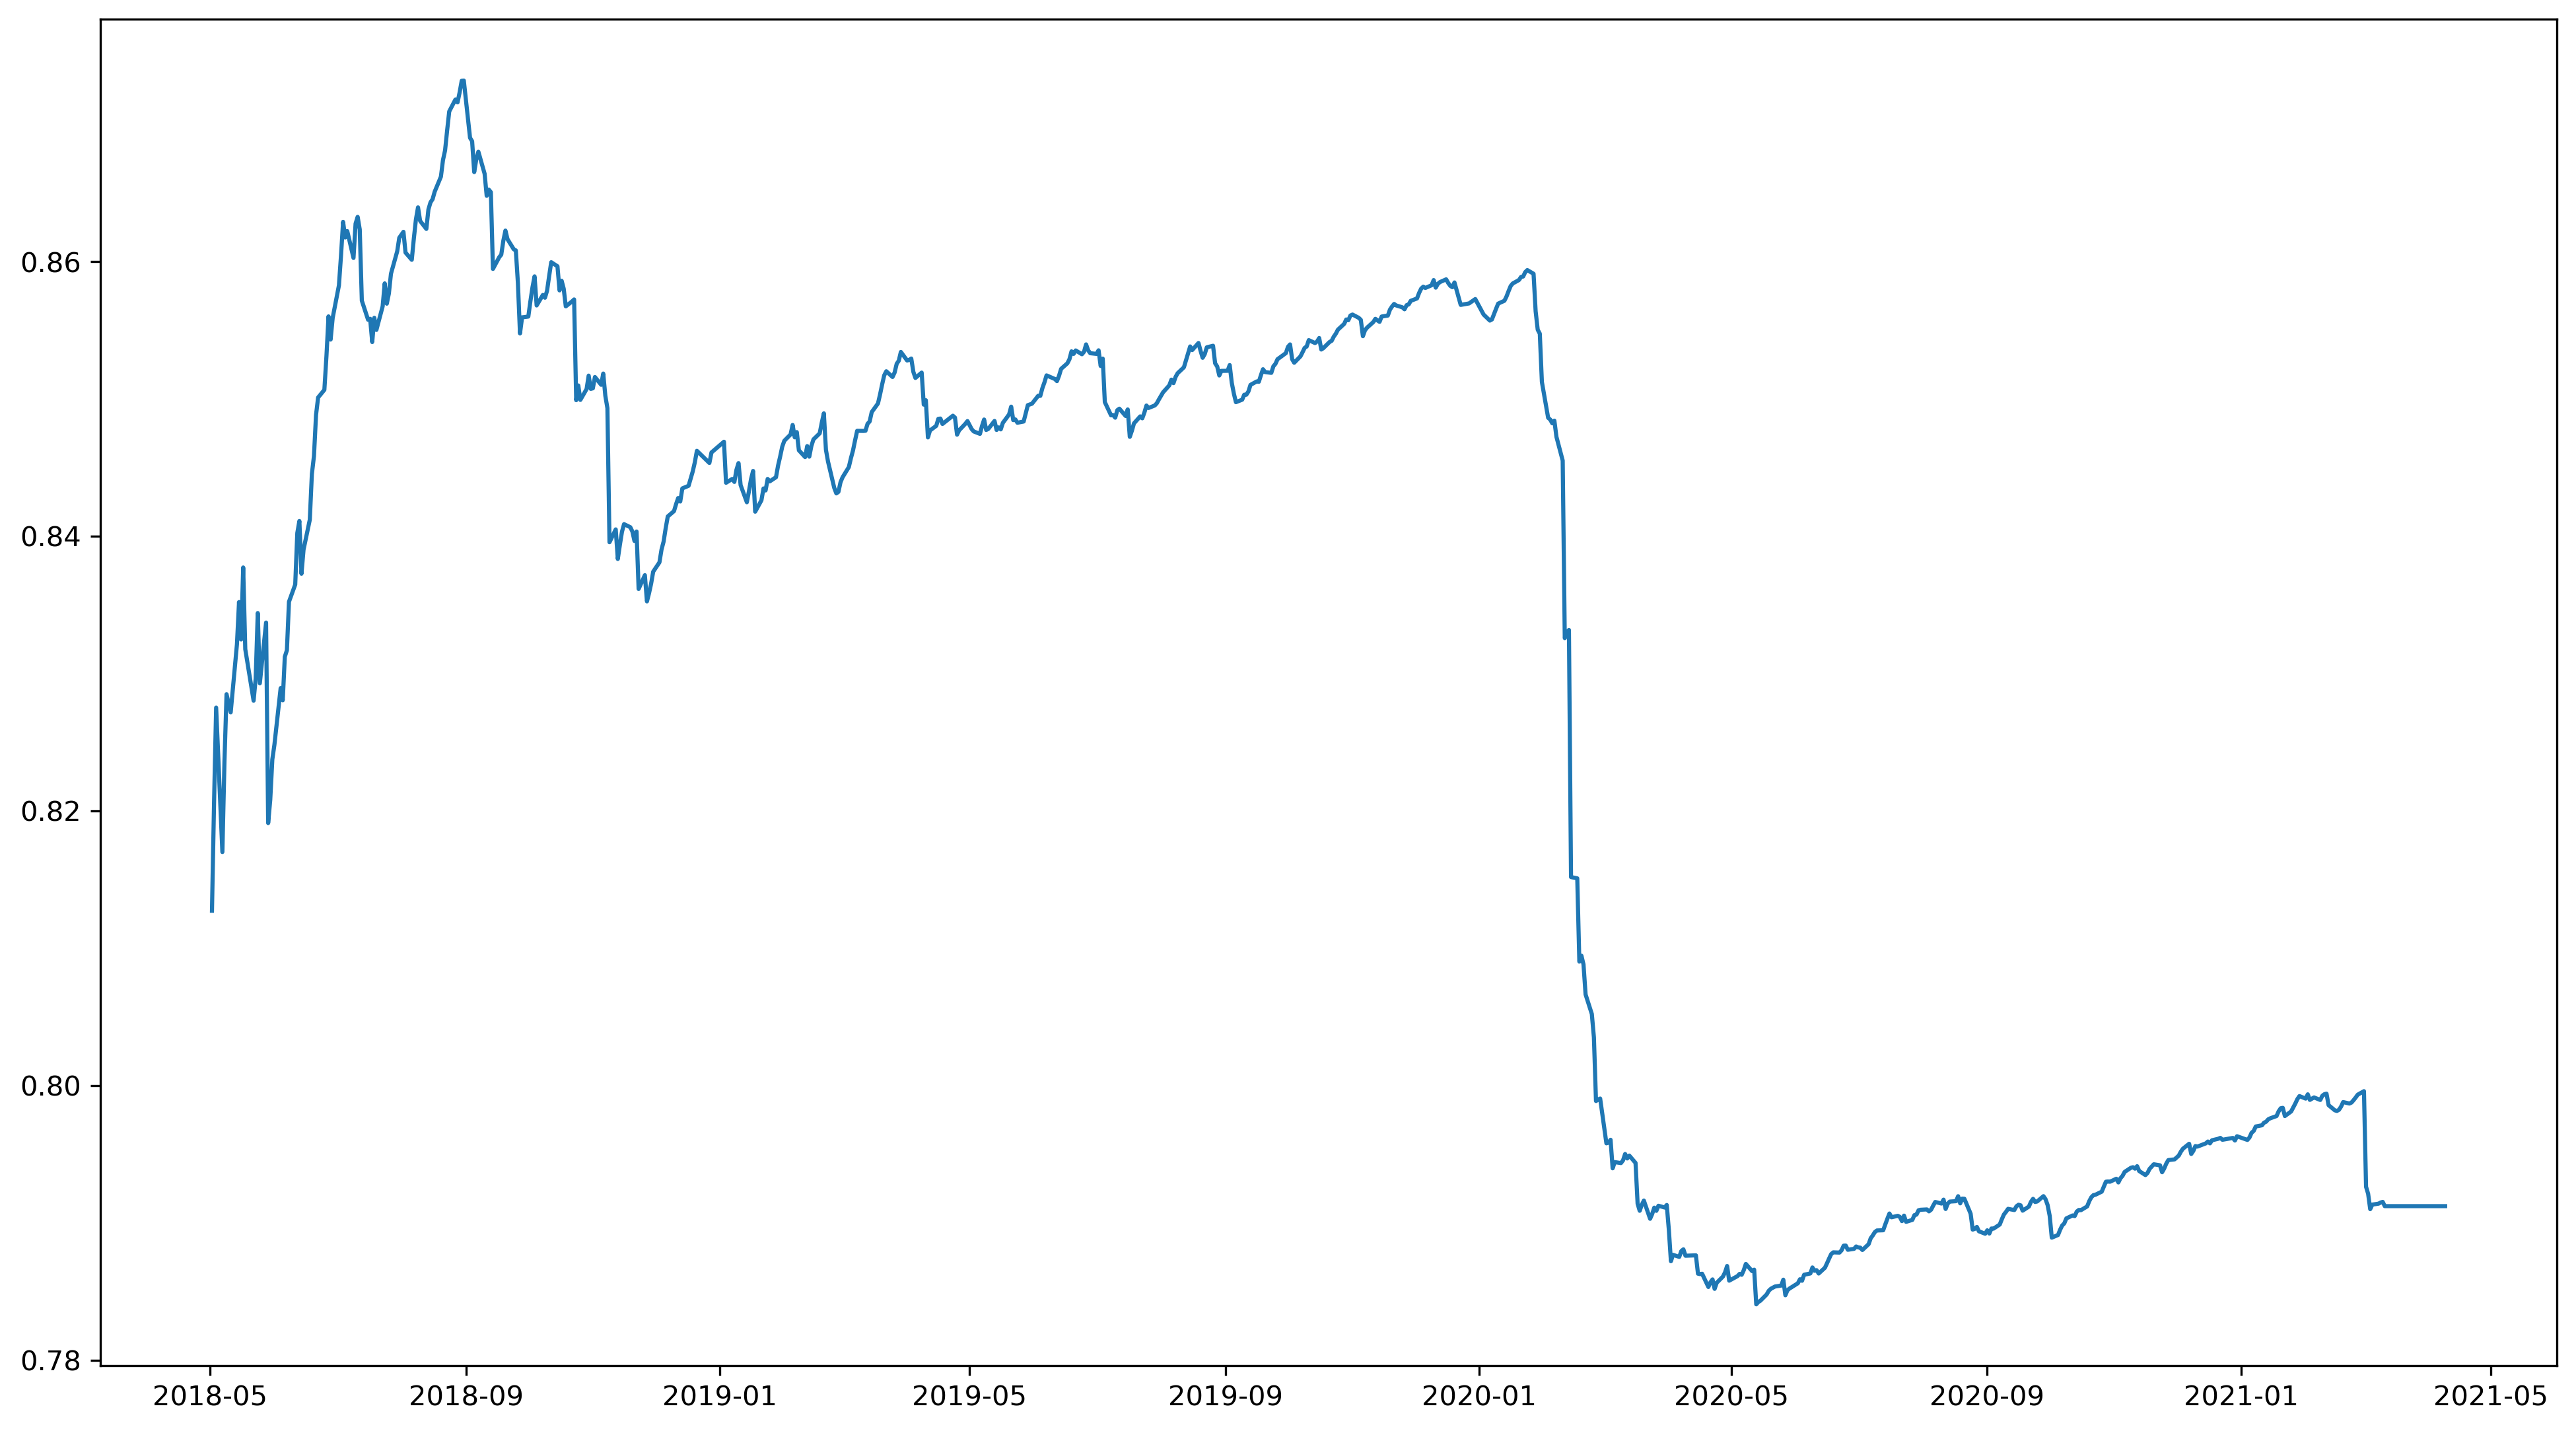

In [62]:
fig, ax = plt.subplots(1,1,figsize=[16,9],dpi=300)
ax.plot(ll)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

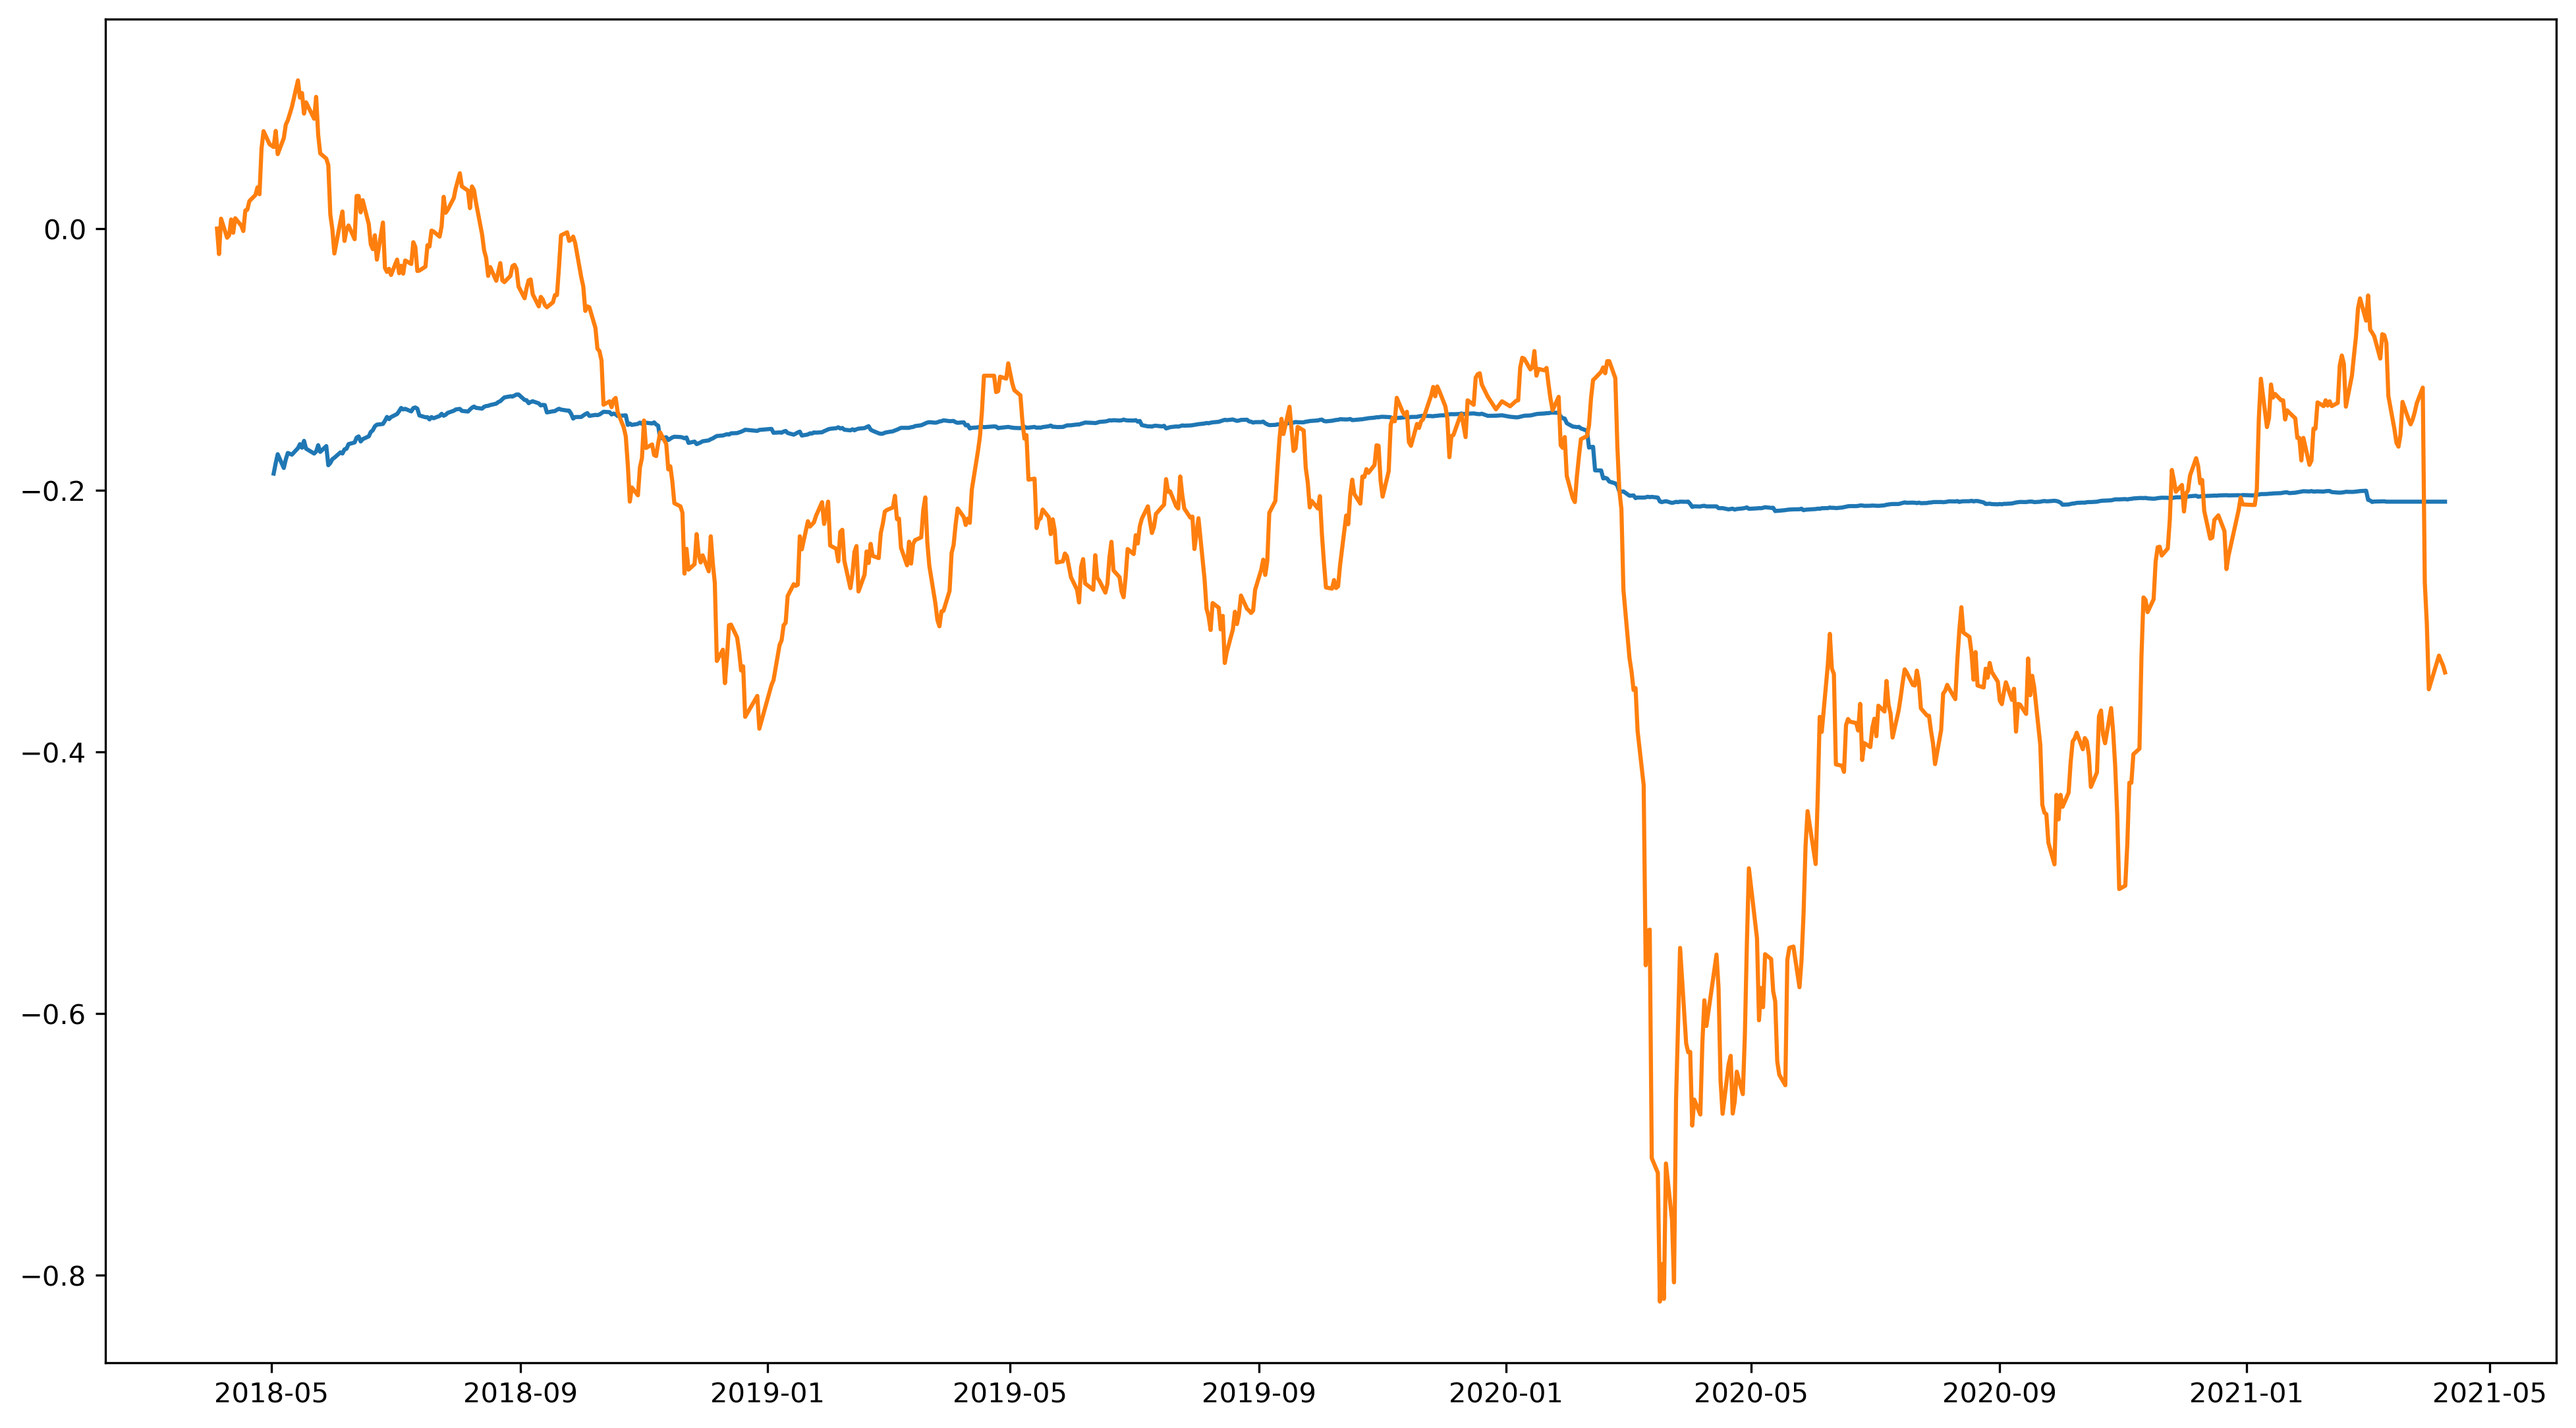

In [63]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(1,1,figsize=[16,9],dpi=300)
ax.plot(-(1-ll))
ax.plot(compounded(cs_logs))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_locator(mdates.AutoDateLocator())